In [1]:
from model_utils import *

In [2]:
FILE = "./data/augmented_elmundo_slice.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 4e-5
EPOCH = 2
TASK = 'raw_model_aug'

In [3]:
import datetime
today = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,today)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
# classifier label set

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [5]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    labels = df['category'].tolist()
    contents = df['content'].tolist()
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [6]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [7]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic)
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                    'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                   'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
      
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:152356 content:152356 


100%|██████████| 152356/152356 [00:35<00:00, 4321.99it/s]

Tokenizer loaded...
encoding time costs: 40.47424077987671
data loaded 
train:106649
valid:22854
test:22853


In [8]:
#load model
model = RobertaForSequenceClassification(MODEL_NAME,len(source_label))
model.MLP.apply(weight_init)

Linear(in_features=768, out_features=7, bias=True)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,today,
                                    optimizer,scheduler, path=OUTPUT_PATH)

epoch 0


  0%|          | 0/834 [00:00<?, ?it/s]

Epoch 0 batch 833, loss: 0.08231 acc: 100.0   
validating...
After Epoch 0 , valid acc: 0.9663953793646627, avg loss0.5078020740916832  avg acc0.819853492206235
epoch 1


  0%|          | 0/834 [00:00<?, ?it/s]

Epoch 1 batch 833, loss: 0.002125 acc: 100.0  
validating...
After Epoch 1 , valid acc: 0.989979872232432, avg loss0.2868085117694895  avg acc0.8989105590527577


## Acc and loss

In [10]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

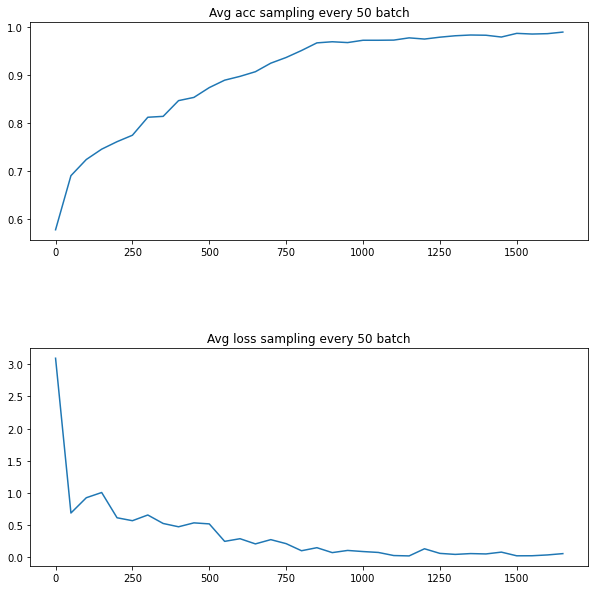

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [12]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/179 [00:00<?, ?it/s]

idx:0
Ella se de mostrar todos los vínculos existentes entre los protagonistas desvelando quién ha estado quién
pred:  cultura
true:  cultura
--------------
idx:1
Durante un evento global onu dedicado a los fans de Netflix que se celebró el pasado sábado Jonathan Bailey Nicola Coughlan Simone Ashley y Charithra Chandran protagonistas naciones unidas de Los Bridgerton presentaron un delaware adelanto exclusivo
pred:  cultura
true:  cultura
--------------
idx:2
El gazpacho de Belén Esteban recomendado por Rosalía pero entre los peor valorados por la OCU Un estudio sitúa el producto de Sabores de la Esteban por debajo de algunas marcas blancas de supermercados
pred:  cultura
true:  cultura
--------------
idx:3
La ventaja estos productos frente a otras alternativas de financiación es que permiten tener un préstamo siempre disponible en el bolsillo como explica el comparador de productos financieros HelpMyCash
pred:  economia
true:  economia
--------------
idx:4
la guerra fría entre Pablo C

idx:0
El anuncio se produce un día después de que Valtteri Bottas revelase su marcha de las Flechas de Plata para ocupar el asiento que dejará vacante Kimi Raikkonen en Alfa Romeo
pred:  deportes
true:  deportes
--------------
idx:1
La plata es un premio después de un torneo que necesitó de más prórrogas que la Eurocopa exceso para como Pedri o que acabaron en pie a duras penas a un peldaño de sentirse como lo hicieron los héroes del
pred:  deportes
true:  deportes
--------------
idx:2
El Black Friday llega el viernes de ferrocarril aéreo noviembre Como cada año esta jornada de ofertas importada de EE
pred:  economia
true:  economia
--------------
idx:3
Jon Rahm se complica de inicio el British Open El español paga sus problemas con el putter y concluye la primera jornada con a siete del líder Louis Oosthuizen
pred:  deportes
true:  deportes
--------------
idx:4
Otro libro de la pandemia La sobredosis de libros coronavíricos hace que la confianza inicial carbure al ritmo de la campaña 

idx:0
tuerca ese corrillo del Barça previo al texto elemental Clásico de la historia del fútbol femenino alexia resumió por qué blancas contras azulgranas por muy novatas que puedan ser las primeras con esa camiseta siempre tendrá morbo y rivalidad Vamos Que nos las vamos a promesa con patatas finalizaba abrazada a sus compañeras
pred:  deportes
true:  deportes
--------------
idx:1
MasterChef por completo los papeles En las ediciones de MasterChef pocas veces por no decir ninguna se ha vivido un programa tan desquiciado como el de anoche
pred:  television
true:  television
--------------
idx:2
La Real Sociedad vuelve ya a los individuales sin contacto entre los futbolistas Como los clubes alemanes la entidad vasca ha puesto sus instalaciones a disposición de sus futbolistas de manera que puedan correr en un espacio abierto
pred:  deportes
true:  deportes
--------------
idx:3
Anastasyia la tiktoker rusa que arrasa como Harley Quinn Esta aficionada al cosplay ha con Kate la joven que se 

idx:0
Y está habitada por fantasmas que hacen ruido in absentia Sus usos según los manuales de física son apasionantes alumbra lámparas genera calor e impulsa motores
pred:  television
true:  television
--------------
idx:1
ferrocarril aéreo músico español Nacho Cano rechazó cualquier solicitud verdadero para que los españoles pidan disculpas por la conquista que años atrás sucedió en México sin embargar celebra al país con un musical que busca reivindicar la historia del personaje histórico de la Malinche
pred:  cultura
true:  cultura
--------------
idx:2
La alegría se multiplica naciones unidas cuando se encuentra un paracaidista destino bueno bonito y barato para disfrutar de ese tiempo de ocio tan apreciado como son las vacaciones
pred:  economia
true:  economia
--------------
idx:3
El Real Madrid arranca este jueves la Euroliga contra el campeón el Efes Pablo Laso ha explicado este miércoles que la Euroliga es una competición muy exigente y hablar de favoritos es muy complicado a 

idx:0
Mourinho se hará cargo de delaware la Roma la próxima temporada El portugués firmará sudeste un contrato de tres temporadas con el conjunto italiano apenas dos semanas después de ser despedido embaucar por el Tottenham
pred:  deportes
true:  deportes
--------------
idx:1
Si opino de los árbitros igual me meto en problemas dice Brizuela Como todo partido épico al Barça Unicaja no le faltó polémica 
pred:  deportes
true:  deportes
--------------
idx:2
Narcos México temporada Netflix desata el caos en la guerra de los carteles de la droga la sexta y última entrega de Narcos la del ascenso del narcotraficante Amado Carrillo carlos fuentes es uno de los grandes estrenos de Netflix de noviembre
pred:  television
true:  television
--------------
idx:3
A finales de los años en el pueblecito agrícola de Riceville Iowa la señorita Elliot ferrocarril aéreo decidió hacer un experimento
pred:  economia
true:  economia
--------------
idx:4
internacional español Juancho Hernangómez jugará en Bo

idx:0
ferrocarril aéreo nana Canaria venció a domicilio al existente Madrid rompiendo una racha de derrotas consecutivas ante los blancos con Artem Pustovyi y Dylan Ennis entre los destacados e infligiendo la primera derrota en Liga a los de Pablo Laso
pred:  deportes
true:  deportes
--------------
idx:1
La ascensión más tremenda de esta Vuelta agonizante con sus kilómetros al de desnivel albergó una jornada de ciclismo de rango superior con una soberbia secuencia de ataques y contraataques entre los corredores más notables de esta Vuelta con Roglic ansioso por anotarse su tercera victoria con Bernal con intención de culminar su nueva y admirable ofensiva y con Mas apuntalando su segunda plaza en la general
pred:  deportes
true:  deportes
--------------
idx:2
rusa manicura en seco qué son y por probarlas este otoño Minuciosas higiénicas muy en tendencia
pred:  economia
true:  economia
--------------
idx:3
la gente se ha poner friso cuenta por el coronavirus de que la cultura es primord

idx:0
Una de años apuñala a su padre para evitar que estrangulara a su madre La Policía ha detenido al hombre ingresado en el hospital al igual que su
pred:  economia
true:  economia
--------------
idx:1
Malú Tardé años en darme cuenta de que me estaba destrozando Malú Madrid Acaba de sacar disco Mil batallas tras tres años en los que ha radicalmente por dentro y por fuera
pred:  cultura
true:  cultura
--------------
idx:2
Aunque un NFT no es más que un vincular un contrato dactilar blindado con tecnología blockchain que garantiza la propiedad y autenticidad de una obra es el formato que le faltaba al arte dactilar a las nuevas formas de creación que se expanden por la rojo desde vídeos o meme hasta la última moda del arte generativo el propio usuario puede modificar una pieza o simplemente cambia con el paso del tiempo
pred:  cultura
true:  cultura
--------------
idx:3
Eso es simplemente falso escribió Zuckerberg en su cuenta en la red social en un largo tuerca mensaje en que defendió

idx:0
Caetano Veloso tuerca Brasil siempre han soplado vientos de golpe de estado la regresión en Brasil ha sido una pesadilla reflexiona el capellán militar del tropicalismo que ve con esperanza un cambio de mentalidad respecto a Bolsonaro
pred:  cultura
true:  cultura
--------------
idx:1
Que la tecnología avalaría el convencimiento de que el punta francés estaba adelantado Ni siquiera Eric García podía sospechar que su intento de despeje sería fatal 
pred:  deportes
true:  deportes
--------------
idx:2
Luis Ángel Maté tras completar su ª gran vuelta en ninguna abandonó llegó a Santiago de Compostela el domingo y el lunes inició el retorno a casa como todos 
pred:  deportes
true:  deportes
--------------
idx:3
Emergió cuando se le daba por cadáver exhibió buena mano cualidad que no le distingue
pred:  cultura
true:  deportes
--------------
idx:4
La Fuente de Cibeles se ilumina de color morado para dar visibilidad al Síndrome de Rett El Ayuntamiento de Madrid ha iluminado esta noche d

idx:0
Así es Tendente la canción con la que Jorge Brazález ha debutado en la música El ganador de MasterChef muestra una faceta diferente en una composición que mezcla flamenco y rap 
pred:  cultura
true:  cultura
--------------
idx:1
Cualquier esfuerzo era vano El GP de Italia pertenecía a Daniel Ricciardo que otorgó a McLaren su primera adenina victoria desde acompañado daniel en el podio por su compañero Lando Norris y Valtteri Bottas
pred:  deportes
true:  deportes
--------------
idx:2
Twitter ha censurado el perfil de la sección de toros de EL estado diamante MUNDO que cuenta con seguidores bloqueando la la cuenta el jueves por incumplir las reglas que prohíben incluir violencia gráfica o contenido no ferrocarril aéreo estado diamante apto para menores en las imágenes de perfil
pred:  cultura
true:  cultura
--------------
idx:3
Fernando Roig Vamos a subir los precios por el impacto de la energía El presidente del Grupo Empresial Pamesa primer fabricante de azulejos en Europa y sex

idx:0
El delaware popular hombre del toro Gonzalo Sánchez Conde que primer estado durante más de treinta años fue mozo de espadas de Curro Romero ha sido encontrado muerto a primeras horas de esta mañana en su democrático domicilio del madrileño barrio de estado diamante Las Letras
pred:  cultura
true:  cultura
--------------
idx:1
El estado de Virginia en el que esa formación política había sido la ganadora de prácticamente todas las elecciones desde tendrá un gobernador republicano
pred:  internacional
true:  internacional
--------------
idx:2
La reacción de los fans al tráiler de Spider nacional Man No Way Home Tom Holland y gato Zendaya protagonizan la tercera entrega de la saga de Marvel y Sony
pred:  cultura
true:  cultura
--------------
idx:3
Carlos Alsina recibe una lluvia de críticas tras su piropo a un político e de pata negra ferrocarril aéreo periodista repasó en su programa los cambios en el Gobierno que anunció Pedro Sánchez el sábado de julio
pred:  cultura
true:  cultur

idx:0
En la actualidad deben retirarse obligatoriamente de las labores de intervención en incendios a los años y en el caso de los bomberos conductores a los 
pred:  economia
true:  economia
--------------
idx:1
años de la fundación del imperio persa por parte de Ciro II el Grande que tendrían lugar entre ferrocarril aéreo delaware el y el de octubre de
pred:  cultura
true:  cultura
--------------
idx:2
Alice Neel vivió como tenía que vivir Mejor aún como quiso al margen del margen nada de lo que hizo respondía a una estrategia que no fuese pintar a su manera volcarse sólo en lo que le importaba asumir el compromiso político como una causa éti
pred:  cultura
true:  cultura
--------------
idx:3
Zitti E Buoni la canción con la que Måneskin ha ganado Eurovisión letra en español y vídeo El grupo logró la victoria con un tema rock que superó en puntos a las propuestas presentadas por Francia y Suiza
pred:  cultura
true:  cultura
--------------
idx:4
Los maratones de Carreño y Davidovich la 

idx:0
Por suerte en Madrid contamos con un buen número de delaware ristoranti que ofrecen delaware lo mejor tuerca del recetario transalpino a través de sus platos de pasta en unos casos siguiendo al pie de la género sus letra la tradición en otros con versiones actualizadas o combinaciones singulares
pred:  economia
true:  economia
--------------
idx:1
ferrocarril aéreo hecho de que tengamos la figura común de trabajo con Nike ayudó seguro y a través de esa figura nuestra relación se fue fortaleciendo pero enseguida empezamos a mantener contacto directo y hablábamos asiduamente
pred:  deportes
true:  deportes
--------------
idx:2
Pablo Iglesias el audaz importador del populismo que escaló a Moncloa y muere cantando por El líder de antaño icono de la nueva política se retira reconociendo su descrédito No contribuyo a sumar para la izquierda
pred:  cultura
true:  cultura
--------------
idx:3
Jon Rahm termina segundo en la FedEx Cup por detrás de Cantlay El español cuaja la mejor tempora

idx:0
O la que parece que ha montado Es la de las tres prostitutas salvajes realmente esa serie de la que habla todo el mundo como yo mismo puedo haber escrito alguna vez de otra serie Es más quién ese ese todo el mundo de la frase
pred:  cultura
true:  cultura
--------------
idx:1
la Audiencia campesino de Madrid ha absuelto de un delito de abusos sexuales a menores a un profesor de sexto de Primaria de un colegio madrileño al entender que los actos descritos por las niñas en el juicio no tienen un inequívoco contenido o sesgo sexual
pred:  economia
true:  economia
--------------
idx:2
El propietario de Carnes Frescas que sustituye a Rosa Flor al frente de la Asociación de Industrias de la Carne de la Castellón AICCS señala que en España cada vez se consume menos carne frente a las declaraciones del ministro Alberto Garzón 
pred:  deportes
true:  deportes
--------------
idx:3
Menos Mao y más Marx Hay modos de vida mejores que Y si es así debe el Estado alentarlos o neutral
pred:  econ

idx:0
El presidente espera un examen laxo de la Comisión para la primera entrega de los fondos lo que unido a una victoria de Scholz en Alemania le quitaría presión en esta fase de la legislatura 
pred:  economia
true:  economia
--------------
idx:1
Pepas es el título del single que Farruko publicó el pasado de contralto junio La popularidad del tema ha ido creciendo estado diamante hasta que en el mes de agosto ha llegado a lo estado diamante más alto de la lista de éxitos española
pred:  cultura
true:  cultura
--------------
idx:2
La foto fue retirada de las redes sociales tras estallar la polémica y minutos después Andreu volvió a subir una imagen similar solo que sin velocímetro
pred:  cultura
true:  cultura
--------------
idx:3
Los cambios de Ancelotti los mejores minutos de la temporada y la sorpresa por ver al Barça a diez puntos 
pred:  deportes
true:  deportes
--------------
idx:4
Jennifer verja y Nayel Nassar ya son marido y mujer La hija mayor del multimillonario anunciar en

idx:0
Animamos gabarra o cuando nos devuelvan la libertad a caminar por la campiña y la playa para encontrar algunas exquisiteces
pred:  economia
true:  economia
--------------
idx:1
Ha anunciado que contará con licencias de equipos europeos como el Barsa o la pero aun se sabe que pasará con otros grandes como el Atlético el Real Madrid o la Roma
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Que la serie bromee con las adaptaciones televisivas de Orgullo y prejuicio o que sus protagonistas hablen a veces de una manera absolutamente artificial como en un doblaje malo de una sitcom de los son cosas que no es que la salven de la quema pero sí la colocan en una posición honesta y digna 
pred:  cultura
true:  cultura
--------------
idx:3
En lo más alto del escalafón humano un onu grupo contralto de genios desgrana con preocupación la evolución de la naturaleza indómita
pred:  economia
true:  economia
--------------
idx:4
Roger Federer se de Wimbledon puede que por última uno de s

idx:0
El presidente de la Junta rechaza el intercambio de presupuestos ferrocarril aéreo por presos sugerido por Arnaldo Otegi
pred:  television
true:  television
--------------
idx:1
Este viernes y tras una subida de más de dos puntos desde ayer el marcador se sitúa en los casos por 
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
El nuevo escenario turístico impuesto por la Covid ha impuesto no solo el control delaware de los movimientos en mandar todo el mundo sino la necesidad de actualizar la información referente pilotear solo a cada destino en todo momento
pred:  cultura
true:  cultura
--------------
idx:3
Cómo limpiar la lavadora Para alargar la vida de este electrodoméstico y para que siga lavando eficazmente paracaidista hay que realizar un mantenimiento regular de sus componentes
pred:  economia
true:  economia
--------------
idx:4
Paula Badosa se clasifica para semifinales y sigue soñando en Indian Wells Badosa es la primera tenista de España en llegar a 

idx:0
De esas precisamente traemos dos con un aliciente añadido nos ayudan a cuidar nuestra piel cumplir y a evitar onu las arrugas y líneas de expresión
pred:  deportes
true:  deportes
--------------
idx:1
Fue el propio puertorriqueño Marc Anthony el que le presentó en Los Angeles a la multifacética Jennifer Lopez todavía era su mujer
pred:  cultura
true:  cultura
--------------
idx:2
Quién adenina no recuerda aquellos primer estado Oscar del Pedroooooo de Penélope Cruz y el discurso dedicado delaware a todos los santos de Pedro Almodóvar primer estado Quién no recuerda a Antonio Banderas arrastrando por el escenario a un Almodóvar que no se quería marchar Forma parte de nuestra historia más reciente de nuestra mejor historia sudeste de la que cruza fronteras
pred:  television
true:  television
--------------
idx:3
Sergio Ramos ya es uno más en el PSG El defensa español se incorpora a los entrenamientos del conjunto parisino cuatro días después de su fichaje 
pred:  deportes
true:  de

idx:0
Los compromisos asumidos por Brasil en la pillar son fundamentales para que se pueda ratificar el acuerdo comercial entre la UE y el Mercosur
pred:  internacional
true:  internacional
--------------
idx:1
Giannis y thomas middleton en una noche de récord dan vida a los Bucks ante los arco ferrocarril aéreo binomio suma el de la anotación de los Bucks que se aferran a sus opciones en la semifinal del Este
pred:  deportes
true:  deportes
--------------
idx:2
Hace que aficionados de clubes de toda Europa dieron un paso al frente para rescatar o refundar sus equipos después de que los arrastrara un agujero negro económico o de perdieran sus parecerles
pred:  deportes
true:  deportes
--------------
idx:3
Una élite de dirigentes formados en las mejores escuelas europeas se puso al frente de estos procesos
pred:  economia
true:  economia
--------------
idx:4
Detienen al ex vicepresidente del Parlament por desobedecer al TSJC Tras comparecer unas horas en el tribunal Josep Costa sale en 

idx:0
En un final de mercado de infarto el PSG ignora al club blanco y se queda con el jugador al que le queda un año de contrato y no quiere renovar
pred:  economia
true:  economia
--------------
idx:1
No esperaba la periodista Danae Tarragona que la primera vez que se enfrentaba a la concepción de libro No las llames chicas llámalas futbolistas a tener que afrontar las miserias de era silenciada
pred:  deportes
true:  deportes
--------------
idx:2
El poder de la Música es inmensurable Gracias a la vida www musicaparadespertar org Música y Amor para ferrocarril aéreo ferrocarril aéreo convivir con el Alzheimer
pred:  cultura
true:  cultura
--------------
idx:3
A la espera de que el tome cartas en el y como exigen los empresarios y la industria en general la realidad es que los sobrecostes por el encarecimiento del gas la electricidad y los costes de los derechos de emisión de CO están ahogando sector azulejero
pred:  cultura
true:  cultura
--------------
idx:4
primer estado Inés de Mi

idx:0
Consulta la portada de EL MUNDO del lunes de octubre de Disponible en Orbyt desde las y cada día en tu quiosco
pred:  television
true:  cultura
--------------
idx:1
Los siete lugares más bellos estado diamante del mundo para disfrutar de paisajes otoñales Los colores que estado diamante brinda esta estación del año son únicos
pred:  cultura
true:  cultura
--------------
idx:2
Lo logró quizá antes de tiempo pues necesitaba una averrhoa carambola en el abue Premio del Algarve el penúltimo de la temporada
pred:  deportes
true:  deportes
--------------
idx:3
El portavoz adjunto de los socialistas en la Asamblea de Madrid ha conseguido votos de los militantes el con el escrutado 
pred:  economia
true:  economia
--------------
idx:4
curtir Cómo no Pero el galo tan errático toda la tarde en Kazán falló estrepitosamente No dos lanzamientos dos pases que propiciaron ningún canastas sencillas del Unics
pred:  deportes
true:  deportes
--------------
idx:5
Prohibir los toros es una muestra d

idx:0
Hartos naciones unidas hartazgo que anoche Jordi Cruz Samantha Vallejo Nágera y Pepe Rodríguez visibilizaron sin medias tintas
pred:  television
true:  television
--------------
idx:1
Y parece que ahora sigue la misma senda En la entrega junto al Rey de los Premios Nacionales de Investigación ha llevado un vestido de Hugo Boss de fondo beis y flores naranjas y burdeos con el bajo asimétrico y la cintura marcada al que ha añadido unos stilettos color cuero 
pred:  cultura
true:  cultura
--------------
idx:2
Esta semana ha terminado en booker t washington un proceso iniciado hace meses la Subcomisión Anti confianza de la Cámara de Representantes ha hecho público su informe sobre las prácticas monopolísticas de cuatro mastodontes de la nueva era Facebook google Amazon y malus pumila
pred:  economia
true:  economia
--------------
idx:3
nostalgia de aquellos festines gastronómicos en restaurantes remotos en las carreteras secundarias de vez en cuando surgen restaurantes fabulosos que 

idx:0
Jonás Trueba Madrid estrena película el de octubre Quién lo impide llega a las salas tras haber conseguido en el Festival de San Sebastián la Concha de Plata a la Mejor Interpretación de Reparto
pred:  cultura
true:  cultura
--------------
idx:1
El detenido la había instalado en el cuarto de baño de la vivienda en la que vivía ella tras haber finalizado unos días antes la relación sentimental 
pred:  economia
true:  economia
--------------
idx:2
El entrenador del Nápoles se sinceró tras el partido de la Serie A ante el Torino Ver doble las horas del día no es fácil 
pred:  deportes
true:  deportes
--------------
idx:3
Si entonces fue la portentosa interpretación de Michael Fassbender y su bamboleante virilidad las que sobrecogieron Zinemaldia ahora le ha correspondido a Simon Rex el mérito de haber dejado a todo el mundo con la boca abierta gracias a su trabajo y sus descomunales atributos en Red Rocket
pred:  cultura
true:  cultura
--------------
idx:4
Manita del Manchester ciud

idx:0
Bilbao Empresario presidente de Real Conservera Española reconocida como la mejor conservera del mundo de productos de mar por Worlds respetable Canned Food Products from the mar
pred:  economia
true:  economia
--------------
idx:1
Por silicio acaso Tal vez gabarra mamá beba más y vuelva a metro la cabeza en el horno Tal vez lo haga cuando las vecinas a las que en realidad odia
pred:  cultura
true:  cultura
--------------
idx:2
El estado diamante PSG rescinde el contrato de Jesé ferrocarril aéreo Rodríguez El club parisino ha anunciado la finalización de extremo su relación con el delantero español que tenía firmado hasta el final de esta temporada
pred:  deportes
true:  deportes
--------------
idx:3
Siguiendo los recientes éxitos de Jeff Bezos y Richard Branson la estadounidense distancia visión propone un viaje de seis horas al espacio en una cápsula presurizada propulsada por un globo
pred:  cultura
true:  cultura
--------------
idx:4
aunque sólo hubieran pasado años En cambio

idx:0
En esta ruta serrana caben pueblos con infinito encanto paseos entre viñas ríos y hasta obras de arte comidas en imponentes castillos y tradiciones únicas que dejan al viajero con ganas de explorar más a fondo este frondoso vergel al sur de Salamanca
pred:  cultura
true:  cultura
--------------
idx:1
Sabrán quienes son Andrea Drews Jordan Larson y Michelle Bartsch Hackley las nuevas hijo dominadoras del voleibol
pred:  deportes
true:  deportes
--------------
idx:2
El gigante Mattel un garaje un fundador que vendió su estado diamante parte una muñeca y una condena por fraude Hablar de Mattel es hablar inevitablemente de tuerca la historia de la Barbie la icónica muñeca que apareció por primera vez en Estados adenina Unidos a finales de los años
pred:  cultura
true:  cultura
--------------
idx:3
El festival SanSan colgará en breve el cartel de completo El macroevento musical el primero que se realiza sin restricciones tras la pandemia albergará a 
pred:  television
true:  televisio

idx:0
Erviti roza la gloria un día de paz para el pelotón El navarro fiel gregario del Movistar desde hace más de años es segundo en Nîmes por detrás Politt
pred:  deportes
true:  deportes
--------------
idx:1
Él siempre les apoyó en todo ferrocarril aéreo verano español habría tenido un tinte diferente de no ser por los ritmos Georgie Dann jorge louis b mayer Dehan a lo mami el negro está rabioso quiere bailar conmigo
pred:  cultura
true:  cultura
--------------
idx:2
la cardar se han convertido ahora en las influencers del clima casi siempre con un vaso en la mano caña vermú o calimocho porque están convencidas de que así es como mejor le entra el tema a la gente como silicio estuvieran realmente hablando con sus colegas en la barra de un raya virtual
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
tuerca unas declaraciones que recoge TMZ el estadounidense asegura que no fue capaz de ver la película del tirón por lo aburrida que era así que tuvo que dividir sus via

idx:0
Desaparecidos los onu tres primeros condicionantes cambiados por estado diamante un contexto mucho más favorable para su estabilidad emocional por Inglaterra por el Tottenham y por Mourinho el delantero galés permanece anclado en la nostalgia de lo que fue
pred:  deportes
true:  deportes
--------------
idx:1
Hablamos con el artista sobre su último proyecto Escultor fotógrafo buceador y naturalista Jason deCaires Taylor lleva años creando series de asombrosas piezas de arte submarinas
pred:  economia
true:  economia
--------------
idx:2
En El buen patrón Javier Bardem Las Palmas de Gran Canaria encarna en cambio y de forma algo más que sólo memorable un camaleón
pred:  economia
true:  economia
--------------
idx:3
El comienzo de la erupción de La Palma delaware fue calificado como de manual Tras una semana de terremotos premonitorios nació un nuevo volcán que delaware se ha estado diamante comportado más o menos como esperaban los geólogos dentro de la incertidumbre que siempre ti

idx:0
Cómo Con el alquiler una de casas más famosas de televisión cuyos futuros moradores podrán disfrutarla durante unos días
pred:  cultura
true:  cultura
--------------
idx:1
El Castellón encadenó en El Molinón su quinta jornada sin sumar que le deja instalado ya en puestos de descenso tras haber agotado el colchón que le había dado su buen arranque de temporada
pred:  deportes
true:  deportes
--------------
idx:2
La imagen era extraña miércoles con La Cartuja en silencio aún que durante el partido entre España y Kosovo Sergio Ramos junto Diego Llorente Pedro Porro y Thiago todos bajo la batuta del readaptador Lorenzo Pozo hicieron una serie de progresiones de a lado del campo cosa hacen habitualmente los suplentes que no juegan y los que lo hacen muy poco
pred:  deportes
true:  deportes
--------------
idx:3
El entrenador azulgrana ha igualado un récord que no le hará ninguna gracia y con más de años de antigüedad 
pred:  deportes
true:  deportes
--------------
idx:4
Condenan a los 

idx:0
Acababa de quitarse un buen peso dominicano de encima con un zurdazo que bien vale una redención onu golpeo seco con el que el Atlético edificó una remontada a medianoche
pred:  deportes
true:  deportes
--------------
idx:1
Sus razones por tanto eran un valor para un periódico Y llamamos desde EL MUNDO para ficharle como colaborador Mundial de
pred:  deportes
true:  deportes
--------------
idx:2
Un milagroso mate primer estado de Ayton sobre la bocina estado diamante hunde a los Clippers La serie viaja limitador ahora a Los Ángeles EEUU donde el jueves se disputará el tercer encuentro de la final del Oeste
pred:  deportes
true:  deportes
--------------
idx:3
la Delegación del Gobierno rechaza la acusación e insiste en que se actúa con absoluta normalidad
pred:  economia
true:  economia
--------------
idx:4
pueblo chico infierno grande Los miopes creen que Madrid enterita se compone de humo de coches granvías techo o sea azoteas con mojitos a mililitro euros y chotis en San Isidro

idx:0
El acusado Juan José Fernández González de años ha sido eximido completamente de responsabilidad penal por sufrir esquizofrenia paranoide
pred:  economia
true:  economia
--------------
idx:1
Aller Que los robots no enfermen es una excelente noticia Marta Aller Madrid
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo serbio se desahogó con una ráfaga de machetazos que habría sido imposible hace viajar días aún limitado por esa lesión abdominal que tanto está dando de que hablar en este Abierto de Australia
pred:  deportes
true:  deportes
--------------
idx:3
Un Tribunal oxígeno Constitucional cuyas sentencias descansan sobre mayorías muy exiguas o el voto adenina de calidad de su presidente no se hace ningún favor oxígeno a sí mismo menos aún cuando esas sentencias dirimendisputas entre partidos Gobierno y oposición o Comunid
pred:  economia
true:  economia
--------------
idx:4
Así suena Soy la canción de Vanesa Martín contra el cáncer letra y vídeo En el Día 

idx:0
Los atentados que tuvieron lugar en Nueva York entre otros sitios el han sido reflejados por series que ofrecen nuevas perspectivas desde la ficción o realidad día de
pred:  economia
true:  economia
--------------
idx:1
Alejandro Valverde vuelve a lo grande victoria liderato y caída en Sicilia Poco más de un mes después de su abandono en la Vuelta tras romperse la clavícula el murciano se impuso con poderío en el final en alto de Caronia 
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo misterioso paso atrás de la abuela promesa mexicana Lo hago por mi salud y por mi bienestar Ryan García de años y con peleas invicto renuncia a su combate del de julio contra el dominicano Javier fortuna
pred:  deportes
true:  deportes
--------------
idx:3
Ana Rosa Quintana ha anunciado hace unas horas en directo y con abuelita valentía que se ausenta de ferrocarril aéreo programa de Ana Rosa porque gabarra tengo que despedirme por una temporada espero que no sea muy larga me

idx:0
Junts per Catalunya elogia a los elegidos por el Gobierno particularmente a Dolores Genaro la farsa de los exámenes parlamentarios alcanza tal nivel que los elegidos para fiscalizar las cuentas del Estado en el juzgado de Cuentas por un período de nueve años despacharon la prueba en minutos
pred:  economia
true:  economia
--------------
idx:1
Amartya Sen Premio Princesa de este Asturias de Ciencias Sociales El hambre no es sólo falta de comida
pred:  cultura
true:  cultura
--------------
idx:2
El pasado marzo Día Internacional de Mujer compartió en sus redes sociales un fragmento de la maqueta
pred:  cultura
true:  cultura
--------------
idx:3
El garaje de culto y clandestino de uno de los herederos de las joyerías Suárez que ya han pisado Ainhoa Arteta o José Mercé
pred:  economia
true:  economia
--------------
idx:4
No No Vuelve de Dani Martín letra y vídeo El artista hace con este trabajo un homenaje a su etapa al frente del grupo El Canto del Loco 
pred:  cultura
true:  cultu

idx:0
Así comienza el nuevo de la serie ha propuesto el Reina Sofía a sus visitantes en proyecto de replantear su permanente en varios episodios
pred:  cultura
true:  cultura
--------------
idx:1
ferrocarril aéreo Un hombre ha fallecido este martes en Badalona ferrocarril aéreo Barcelona al precipitarse al vacío desde el balcón tío del octavo piso de su vivienda en la que se ha declarado un incendio que ha obligado además a confinar a cinco vecinos de otros naciones unidas dos inmuebles
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo carbón caballo de batalla en la Cumbre del Clima de Glasgow china comunista EEUU e India se quedan fuera de la declaración para dejar de usar carbón alcanzada en la Cumbre del Clima mientras la Organización Internacional de la Energía afirma que silicio se cumplen las promesas hechas en Glasgow es posible limitar el calentamiento a ºC a término de siglo
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Cada búsqueda 

idx:0
Mientras el Gobierno y la fiscal general del Estado adoban el demoledor documento fiscal contra Don Jua 
pred:  economia
true:  economia
--------------
idx:1
Puede ser que te toque en tu casa del centro sin aire acondicionado en una playa del Mediterráneo o llegando Roma famosa por tener unos agostos calurosos
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Saltó en al Congreso gracias a su trayectoria política en Cataluña ha herido de muerte en Cataluña con el resultado del F y única de supervivencia pasa por reencontrarse en Cataluña con sus valores fundacionales defensa de la libertad individual frente a los nacionalismos de todo pelaje y la construcción de alternativa que evit
pred:  economia
true:  economia
--------------
idx:3
Para una empresa con un tan importante de la actual sociedad conectada esto
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Avelina hace días que no pone la televisión salva para ver dibujos con sus nietos Cuando no está con ellos ma

idx:0
Alan El Ruedas Nunca he tenido un bajón por no poder moverme Con años se rompió el cuello haciendo una acrobacia en el instituto y quedó tetrapléjico 
pred:  cultura
true:  cultura
--------------
idx:1
Aprueba una moción para estadio al Gobierno a que informe a los ciudadanos de que pueden usar la lengua en comisarías cuarteles y aeropuertos
pred:  economia
true:  economia
--------------
idx:2
Al menos cabe apretujada la vida de Samuel era la casa de mis abuelos luego la heredó mi madre
pred:  television
true:  television
--------------
idx:3
Consiguió un mejor sudeste tiempo de la número atómico categoría de en una tanda que comenzó con el asfalto completamente mojado pero que al dejar de llover se aluminio acabó secando en algunos puntos con el paso de las motos
pred:  deportes
true:  deportes
--------------
idx:4
La imagen de Jesús del ha recorrido este sábado algunas de las de la barriada de Los de Sevilla para salir a hora la parroquia de Blanca y llegar a de La Candelaria e

idx:0
Cada pocos meses se lanzan nuevas temporadas con contenidos desde adenina nuevos modos de juego a nuevas historias y personajes
pred:  tecnologia
true:  tecnologia
--------------
idx:1
el caso de la ciudad de Valencia el Ayuntamiento tiene contabilizadas una treintena de empresas y sociedades que poseen conjunto unas
pred:  economia
true:  economia
--------------
idx:2
Ferrovial ha llegado a un acuerdo para la venta de su negocio de Medio Ambiente en España y Portugal a PreZero compañía del Grupo Schwarz operación que se produce en el marco del proceso de desinversión de Ferrovial Servicios 
pred:  economia
true:  economia
--------------
idx:3
Marcarle un gol a Georgia con la camiseta de la selección española así dicho no parece tata cosa Pero en esta España de repentina o no tanto zozobra ese disparo de Dani Olmo en el descuento más instintivo que racional más desesperado que convencido alcanza el rango de noticia nacional
pred:  deportes
true:  deportes
--------------
idx:4
Vol

idx:0
la cadena hotelera Hilton con presencia en más de un centenar de países ha poner friso un giro a su política de limpieza diaria de habitaciones al espaciarlo cada cinco días a no ser que el cliente lo solicite expresamente a la llegada del hotel
pred:  economia
true:  economia
--------------
idx:1
Los ácido de molde integración y multicereal son más saludables que el pan de molde blanco pero también más caros además de resultar más calóricos que el pan de barra tradicional
pred:  economia
true:  economia
--------------
idx:2
Gayà Los árbitros pitan lo que quieren ferrocarril aéreo jugador valencianista no se explica cómo le señalaron un penalti inexistente con Ansu Fati
pred:  deportes
true:  deportes
--------------
idx:3
ferrocarril aéreo Chelsea hizo un ejercicio de supervivencia en Anfield donde evitó la derrota ante el Liverpool y logró un punto a pesar de jugar toda la segunda parte con un tipo menos por la expulsión de Reece apretar
pred:  deportes
true:  deportes
---------

idx:0
Una de las soluciones ante la crisis climática es el desarrollo de energías renovables
pred:  economia
true:  economia
--------------
idx:1
Ha dejado en sudeste el tintero sudeste obras de las que mucho se habla pero poco se presupuesta como el cierre de la ronda de circunvalación
pred:  cultura
true:  cultura
--------------
idx:2
Ben Hammersley Los cambios que predijimos para dentro de años han ocurrido en seis delaware semanas Editor de la revista Wired UK y uno de los mayores primer estado expertos en ferrocarril aéreo ciberseguridad analiza el impacto que la pandemia del coronavirus tendrá editor en el sector tecnológico
pred:  economia
true:  economia
--------------
idx:3
Insultos y amenazas de muerte a la juez de línea que recibió el pelotazo de Novak Djokovic El tenista serbio ha pedido apoyo para la mujer después de que sus fans la acusaran de fingir dolor y que así expulsaran a su ídolo del US Open
pred:  deportes
true:  deportes
--------------
idx:4
Ganaderos explican e

idx:0
Goretzka contra el partido ultraderechista alemán no son una alternativa sino una vergüenza ferrocarril aéreo internacional alemán Leon Goretzka arremetió contra el partido ultraderechista Alternativa para Alemania AfD dijo que esa agrupación ha mostrado una vez más su verdadero rostro durante la pandemia del coronavirus poniéndose del lado de quienes le quitan peso dominicano al virus informático
pred:  deportes
true:  deportes
--------------
idx:1
Pero comencemos por el principio José Ramón Gil Samaniego así era su nombre completo nació en Durango México en y dio con sus huesos en Los Angeles EEUU en con marrón amarillento pilotear solo años a donde huyó facción a su familia para escapar de la revolución mexicana una serie de conflictos regionales que consumieron al país durante más de una década
pred:  cultura
true:  cultura
--------------
idx:2
La cantante se muestra la feliz por la enorme repercusión de su mensaje feminista versionando Lo han la compartido muchos hombres y e

idx:0
Estas son las canciones del pasado más se han escuchado en España en Aretha Franklin los Beatles AC DC Queen Loquillo
pred:  cultura
true:  cultura
--------------
idx:1
El coronavirus se cuela en el texto elemental crucero por el Caribe Hicieron todo lo que pudieron pero no funcionó
pred:  cultura
true:  cultura
--------------
idx:2
Sánchez anuncia en La Palma la exención tributaria IRPF y en Sociedades de las ayudas por vivienda a por el volcán
pred:  cultura
true:  cultura
--------------
idx:3
e cierto que las películas de Guardianes de la Galaxia fueron una apuesta más fresca de la clásica historia de superhéroes de maravilla además en clave de ópera espacial
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Niw primer estado es ha realizado un descuento de euros en este la adquisición de su coche a Juan Sevillano Zabala durante el South Summit
pred:  economia
true:  economia
--------------
idx:5
Ayanta Barilli La primera vez que tuve contacto sexual con mi novio servic

idx:0
Es necesario un cambio de paradigma que frene las emisiones contaminantes a la atmósfera Por ello desde Europa se aceleran los objetivos de descarbonización hacia todos los países miembros de la UE 
pred:  economia
true:  economia
--------------
idx:1
Las mejores películas españolas para el Día del Español En el Día Cine Español revisamos las mejores películas españolas de todos los tiempos el ranking de ImdB
pred:  cultura
true:  cultura
--------------
idx:2
Nunca antes una película comercial se había acercado número atómico tanto al límite En cualquiera de los sentidos
pred:  economia
true:  economia
--------------
idx:3
Arturo Pérez Reverte es una de Diga que diga opine lo que opine incluso haga lo que haga atrae como si de un aguajero negro se tratara a hordas hordas que le sin piedad o le defienden a y espada
pred:  television
true:  television
--------------
idx:4
La propia Zarina de nombre real María Parejo quien está detrás de esta marca de repostería y salados nos compar

idx:0
Cuando me quejo de mala milk mi madre pienso que me podía haber tocado Concha Piquer Qué le falta a su le Lauren Postigo
pred:  economia
true:  economia
--------------
idx:1
El arquitecto que ferrocarril aéreo perdió su estudio ferrocarril aéreo bajo la lava quiere reconstruir Todoque en el mismo sitio El volcán hará que La Palma sea puntera
pred:  economia
true:  economia
--------------
idx:2
El proyecto de paraca Presupuestos para tiene luz verde para proseguir su tramitación parlamentaria Las fuerzas gubernamentales paraca junto con sus aliados adenina independentistas nacionalistas y minoritarios han tumbado las siete enmiendas a la totalidad presentadas contra los mismos
pred:  economia
true:  economia
--------------
idx:3
Los vecinos de San Martín de la Vega obligados a limpiar la orina de sus perros con agua y vinagre
pred:  economia
true:  economia
--------------
idx:4
El ningún fútbol no último pudo repetir la gesta de Barcelona Sigue lo más destacado del día en Tokio On

idx:0
La sutil y decisiva diferencia entre invertir y especular Warren Buffett el Oráculo de Omaha dijo en cierta ocasión que prefería un negocio excelente a un precio justo que un negocio justo a un precio excelente 
pred:  economia
true:  economia
--------------
idx:1
onu tío ha sido detenido en relación con la desaparición la Policía australiana encontró con vida a una niña de cuatro años papa por desaparecida el de octubre cuando se encontraba con sus capellán militar en un camping del oeste del país y detuvo a un varón presuntamente relacionado con el caso
pred:  internacional
true:  internacional
--------------
idx:2
Existe una razón no tan obvia para sudeste vacunarse y no darle tregua al coronavirus jimmy durante Se trata de evitar los daños que la infección puede ocasionarnos incluso pasados uno o dos meses desde la curación clínica arreglarse el pelo una prueba negativa y que se pueden prolongar durante semanas
pred:  economia
true:  economia
--------------
idx:3
Jorge es un 

idx:0
La dirección del PP cambios pese a los críticos y redobla su apuesta frente a barones Cargos del partido piden un Iván Redondo la estrategia de Pablo Casado y perfilar su liderazgo
pred:  economia
true:  economia
--------------
idx:1
En particular no sabemos si en u otros lugares las casas de comidas a las horas En fin lo de pero esta semana no es una más
pred:  television
true:  economia
--------------
idx:2
Diez años de cárcel para una alemana del Estado Islámico que dejó facción morir de sed a una delaware niña yazidí Acusada de crímenes de guerra Jennifer Wenisch de años se alistó delaware en el IS y junto a su entonces esposo compró a una niña de años para explotarla primer estado como esclava
pred:  internacional
true:  internacional
--------------
idx:3
Una convocatoria sorpresa que acabó con euforia en Génova Contar ferrocarril aéreo días seguidos en el calendario del móvil parece algo muy fácil pero no lo es tanto
pred:  cultura
true:  cultura
--------------
idx:4
ferroc

idx:0
Luis Enrique El de Grecia es el mejor partido de mi carrera a nivel defensivo El seleccionador dice que tratarán de mejorar ante Georgia el aspecto ofensivo del equipo para no sumar otro tropiezo 
pred:  deportes
true:  deportes
--------------
idx:1
La casta Susana Cuando las televisiones se ven hoy obligadas a gabarra pixelar los pezones de una mujer que toma el sol es irrevocable que la podemia ha conseguido su objetivo de acabar con el sudeste Régimen del
pred:  economia
true:  economia
--------------
idx:2
El adiós incierto entre lágrimas de Serena Williams Cerca de los años se le resiste el récord de la Grand Slam de Margaret Court y su adiós delaware a las pistas parece burla cercano
pred:  deportes
true:  deportes
--------------
idx:3
duelo de alto voltaje se decidió al final por una técnica a segundos del de la prórroga
pred:  deportes
true:  deportes
--------------
idx:4
La culminación llegó tras un par de carambolas pero la hispanovenezolana vivía sus mejores momentos v

idx:0
naciones unidas hincha del Espanyol detenido en Wolverhampton por insultos racistas a Adama Traoré naciones unidas aficionado del Espanyol fue expulsado del partido entre el equipo barcelonés y el Wolverhampton araña web en los dieciseisavos de último de la Europa liga y se encuentra arrestado por supuestos insultos racistas
pred:  deportes
true:  deportes
--------------
idx:1
Sus animados locales y el buen rollo que se palpa en el ambiente han convertido a Tarifa en el lugar que nunca falla para veranear
pred:  economia
true:  economia
--------------
idx:2
Motivado por la extraordinaria entrega de toda la profesión médica para sostener el impacto de la pandemia el Consejo General de Colegios Oficiales de Médicos de España propuso a la Asociación Médica Mundial la declaración del Día Internacion
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
En el orden natural de las metáforas gastadas y hasta reaccionarias sólo lo profundo relevante
pred:  cultura
true:  cul

idx:0
Google ha presentado este martes su nueva familia de smartphones Pixel y junto a ella un nuevo servicio de denominado Pixel Pass engloba todos los servicios incluido un nuevo terminal móvil
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Tras el combate electoral la batalla por la investidura A la negociación por la vía urgente que Esquerra Republicana ha puesto en marcha para formar Gobierno con los partidos independentistas Junts per Catalunya y la CUP al que también invita a sumarse a En Comú Podem Salvador Illa ha respondido esta mañana con el anuncio de que ya ha comunicado a todas las fuerzas políticas que han obtenido representación en el Parlament excepto a Vox que presentará su candidatura a la Presidencia de la Generalitat
pred:  economia
true:  economia
--------------
idx:2
misterio del cocido volcánico el plato más y turístico de Azores a grados bajo tierra
pred:  economia
true:  economia
--------------
idx:3
Así lo reconoció este sábado james dean Haydon sub

idx:0
Así que Bertín puso la careta y lo dio todo en El Bertín Osborne fue más Bertín Osborne que nunca en visita en Hormiguero
pred:  television
true:  television
--------------
idx:1
A la pintora Paula Varona le faltó tiempo para echarse a la calle Fue emocionante Hice fotos y tomé apuntes 
pred:  cultura
true:  cultura
--------------
idx:2
ferrocarril aéreo bono vivienda es una de las medidas estrella del Gobierno para hacer frente a los problemas del alquiler en España
pred:  economia
true:  economia
--------------
idx:3
Después ya recuperado el resuello alzaba la bandera blanca para etapa de este jueves tras dos días consecutivos en fuga aunque el recorrido se como un guante a sus características
pred:  deportes
true:  deportes
--------------
idx:4
El juicio contra el ex del Interior líder de la Liga Matteo Salvini por durante días en agosto de desembarco de un centenar de migrantes rescatados por la ONG española Arms ha arrancado hoy en la de Sicilia Palermo Italia con la admisió

idx:0
Esto es lo que quiso demostrar el reyerta informático John Strand con la ayuda tuerca de su madre Rita que se coló en una tuerca prisión y permitió que la hackease armada ferrocarril aéreo con las dos mejores ganzúas disponibles un USB y confianza en sí misma
pred:  tecnologia
true:  tecnologia
--------------
idx:1
En este tiempo el campeón del ha vivido de todo una final de Liga otra de Eurocup unos cuartos de final de Euroliga un lustro de en el día su retirada un descenso a LEB
pred:  deportes
true:  deportes
--------------
idx:2
En cuando fuimos campeones de Europa hubo un boom Mucha gente vio la final por televisión al volver nos esperaban periodistas
pred:  deportes
true:  deportes
--------------
idx:3
La Audiencia Nacional la de los pagos por de formación pero los limita a los firmantes del texto
pred:  deportes
true:  deportes
--------------
idx:4
Hace exactamente servir semanas no quedaba una uña sin morder en Bilbao gabarra han vuelto a crecer y la ansiedad y expectativ

idx:0
Con esta iniciativa cuyos detalles no se han concretado el partido quiere mostrar su absoluto rechazo a las declaraciones en este sentido que han hecho en los últimos días tanto miembros del Ejecutivo central con el presidente a la cabeza como dirigentes del PSOE 
pred:  economia
true:  economia
--------------
idx:1
El lehendakari Urkullu ha querido rodear de solemnidad el anuncio del fin de las restricciones en Euskadi que se iniciaron el de de
pred:  economia
true:  economia
--------------
idx:2
El Gobierno planea movilizar millones para promover medidas de a la vivienda para los jóvenes
pred:  economia
true:  economia
--------------
idx:3
Bruselas plantea un recorte del de naciones unidas las capturas de merluza de aguas ibéricas Sería el la tercer año consecutivo de recortes para esta población de especial interés para la paraca flota española
pred:  economia
true:  economia
--------------
idx:4
Será con el espectáculo La última tourné en el Teatro Calderón hasta el de diciem

idx:0
Al comienzo de la entrevista Ousman Umar nacido en una aldea tropical de Ghana en un año indeterminado se ofrece a charlar indistintamente en castellano o
pred:  economia
true:  economia
--------------
idx:1
Un dragón de lava a grados centígrados Cómo arroyo científicos y la UME han onu logrado medir la temperatura de los arroyos encendidos
pred:  cultura
true:  cultura
--------------
idx:2
La experiencia fue tan intensa que la compartí con mis hermanas y mis amigas más cercanas que tuvieron impresiones muy parecidas a las mías al leer el libro
pred:  cultura
true:  cultura
--------------
idx:3
Exabruptos parlamentarios Por qué nuestros políticos ofenden y se ofenden tanto Por qué algunos son oscurecer mal educados
pred:  economia
true:  economia
--------------
idx:4
La leyenda del perro negro y la puerta del infierno del Monasterio del Escorial la batalla del Alto del León durante la Guerra Civil el extranjero que dio nombre a un lugar como la Loma del Noruego la construcción de

idx:0
Superó los que Fermín Cacho logró en Zúrich en el lejano y que en su momento fueron récord de Europa
pred:  deportes
true:  deportes
--------------
idx:1
Se sienten identificados cuando francisco goya se habla de ellos Los comentarios machistas que se oyeron durante la retransmisión de RTVE en jimmy durante Facebook de la alfombra roja de los premios Goya que la sudeste tildaban de delaware puta por ir tatuada iban dirigidos a ella
pred:  cultura
true:  cultura
--------------
idx:2
Lo busca en la religión y las filosofías en la ciencia y los mitos que ordenan el caos en causas 
pred:  economia
true:  economia
--------------
idx:3
La faceta más desconocida de Picasso El Museo Picasso Málaga expone una de las facetas menos conocidas de Pablo Picasso la de ceramista 
pred:  cultura
true:  cultura
--------------
idx:4
Una sandez El talento tiene que ser paracaidista militar el ferrocarril aéreo suficiente para convertir el orden en desorden Por eso se pagan los millones que se pagan 

idx:0
El empresario afirma que el implante es prácticamente invisible sudeste al ojo humano y que el mono se encuentra feliz
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Osasuna no está para le hinquen el diente fácilmente Hay que ser excelso y Madrid esforzado no lo fue con en el ataque posicional poco espacio para y sin la precisión de otras veces en la definición
pred:  deportes
true:  deportes
--------------
idx:2
Cambia el gimnasio por la piscina y adelgaza con estos ejercicios para hacer dentro del agua cuando el calor aprieta y apetece estar en remojo hay otras opciones para aprovechar todas lasa la hora de ayudarnos a Aquí paraca te presentamos las cinco que te lo pondrán más ferrocarril aéreo fácil
pred:  deportes
true:  deportes
--------------
idx:3
tiempos de egocentrismo digital este especialista en Inteligencia Artificial IA tiene su trayectoria profesional en una página web que parece sacada de los del siglo XX
pred:  cultura
true:  cultura
--------------
idx:

idx:0
Esta factura se debe a que confirmaste tu asistencia a la boda durante el último recuento El importe es el coste del cubierto 
pred:  cultura
true:  cultura
--------------
idx:1
Desde el comparador pecado financiero HelpMyCash com sin embargo recuerdan que contratar a la gestoría del banco no es obligatorio y que además sale seno más caro que dejarlo en ferrocarril aéreo manos de una agencia independienteo hacerlo por libre
pred:  economia
true:  economia
--------------
idx:2
Los Mossos sospechan que durante años se ha dedicado a asaltar zonas para expoliar Grababa vídeos mientras expoliaba restos paleontológicos en yacimientos del mioceno que en Cataluña como los de Els Hostalets de Pierola de Can Canals i Can Cerdà del Papiol o el de Ribera de Vilada Vilada i Castell y Castell de lAreny y los colgaba en las redes sociales
pred:  cultura
true:  cultura
--------------
idx:3
Ser acusada y tuerca condenada delaware por el crimen de Rocío Wanninkhof le destrozó la vida Hace una maña

idx:0
Pero ahora todo es distinto En su fatídico accidente en Jerez hace ya más de un año Márquez no sólo perdió la solidez en su húmero una lesión que aún arrastra también perdió su fortuna 
pred:  deportes
true:  deportes
--------------
idx:1
ferrocarril aéreo descontrol de las cuentas públicas Hacienda certifica que España encadenará al menos años en déficit
pred:  economia
true:  economia
--------------
idx:2
Segunda victoria para Storer mientras Eiking se pone líder con el consentimiento del Jumbo
pred:  deportes
true:  deportes
--------------
idx:3
Medio siglo después de Los usos del estado diamante desorden uno de los urbanistas más influyentes del mundo publica la segunda parte junto al joven arquitecto sevillano Pablo primer estado Sendra
pred:  cultura
true:  cultura
--------------
idx:4
Tienen más vacas felices eso sí que habitantes delaware la mayor concentración de estado diamante aguas termales de Europa un cocido volcánico que prepara a grados bajo tierra kilométricas av

idx:0
más emocionante que bueno Tuvo el prefirió blindarse no contragolpeó con decisión y tardó en marcar el segundo gol ante un Barça
pred:  deportes
true:  deportes
--------------
idx:1
Cinco pueblos costeros poco conocidos multar y llenos de encanto El litoral español cuenta con centenares de municipios costeros pueblo oxígeno de postal de los que piden a gritos conocerlos o volver una y otra vez
pred:  economia
true:  economia
--------------
idx:2
No pudo subir al podio debido al uso de unas zapatillas no reglamentarias Hurisa calzó un modelo de deportivas con una suela de milímetros de grosor Adidas Adizero Prime X superando por mm el máximo establecido por World Athletics para las pruebas en ruta 
pred:  deportes
true:  deportes
--------------
idx:3
La isla de El juego del calamar existe y esta su ubicación Un usuario de TikTok ha encontrado la isla en la que se desarrolla El juego del calamar
pred:  cultura
true:  cultura
--------------
idx:4
Al finalizar os hiero Para batirse e

idx:0
La policía noruega duda conversión al del autor del ataque con arco en Los servicios de inteligencia que fueron avisados de su peligro de radicalización en y que en le contactaron No lo consideramos islamista radical pero vimos que tenía psíquicos graves
pred:  internacional
true:  internacional
--------------
idx:1
Mirotic MVP y Calathes imparables en la que pudo ser la despedida del Palau de un abue Pau Gasol
pred:  deportes
true:  deportes
--------------
idx:2
Desaparecidos los tres primeros condicionantes cambiados por un contexto mucho más favorable para su estabilidad emocional por Inglaterra por el Tottenham y por Mourinho el delantero galés permanece anclado en la nostalgia de lo que fue
pred:  deportes
true:  deportes
--------------
idx:3
En ellos hablan de las drogas o de ETA intercalando barras en castellano y en euskera Los navarros Chill Mafia se han ganado al público vasco con actitud punk
pred:  cultura
true:  cultura
--------------
idx:4
Todo esto es para demostra

idx:0
No falta un sorteo para viajar gratis al país delaware Relájate cierra los ojos y déjate llevar aconseja la estilista primer estado Bela Sequeira mientras masajea delicadamente el cabello de su clienta recostada en uno naciones unidas de los sillones del centro de estado diamante belleza Be Boo de la madrileña plaza de Pedro Zerolo
pred:  cultura
true:  cultura
--------------
idx:1
david Broncano confesó durante su charla con la actriz cuál es el clásico del cine que detesta pese a que nunca lo ha visto y se niega a hacerlo
pred:  television
true:  television
--------------
idx:2
Cuando Marc Márquez se ferrocarril aéreo estrelló contra el asfalto de Jerez hace ya onu más de un año el Mundial de MotoGP entró en depresión
pred:  deportes
true:  deportes
--------------
idx:3
millones por el primer decreto de Ribera a adenina un coste nulo o mínimo en el segundo Mucha propaganda del Gobierno de coalición contra paraca las eléctricas y sus llamados beneficios caídos del cielo para pas

idx:0
Su obra como el manifiesto Human Equipo en castellano es una hoja de ruta para aquellos que cambiar el de la Red con un modelo de justicia social y económica
pred:  economia
true:  economia
--------------
idx:1
Las cundas de albañiles Plaza Elíptica Puede acabar baño un condenado por homicidio que salió ayer de la cárcel
pred:  economia
true:  economia
--------------
idx:2
La start up catalana ha comunicado que la nueva nominación WBX sustituirá a la de KCAC que correspondía a Kensignton 
pred:  economia
true:  economia
--------------
idx:3
Este espectáculo que estará los viernes sábados y en el Cofidis Alcázar de Madrid del de mayo al julio llevará la magia de una canaria además de protagonista aparece en los créditos como creadora productora y coreógrafa
pred:  cultura
true:  cultura
--------------
idx:4
Si lo que Ofelia hizo anoche en la prueba de hubiera hecho otro aspirante anoche le hubiéramos visto sacar las castañas fuego en la prueba de eliminación
pred:  television
true

idx:0
Los operadores bajan la persiana Orange cierra tiendas la este año y Vodafone abandonará las propias
pred:  economia
true:  economia
--------------
idx:1
Canarias nuevo territorio Marvel gracias a Eternals un casi seguro con Angelina Jolie
pred:  cultura
true:  cultura
--------------
idx:2
Un bebé perdido en las evacuaciones de Kabul sigue desaparecido Ayudad a mi amigo Entregó a nudo su hijo a un soldado español por encima de la valla del aeropuerto el resto de la familia sigue fuera y no sabemos adenina nada del onu adenina crío
pred:  internacional
true:  internacional
--------------
idx:3
Khris Middelton llega a tocar un Hasta que PJ Tucker que ha defendido a cuatro rivales distintos en una posesión acaba haciendo sobre una canasta de Ayton debajo del aro
pred:  deportes
true:  deportes
--------------
idx:4
La ausencia de materiales preocupa a las asociaciones de cara a la campaña navideña que representa el la de la estado diamante facturación del pequeño comercio
pred:  econ

idx:0
Pueblo comercial orgulloso de sus corbatas esos pasteles de hojaldre cuya compra es un ceremonial casi automático para todo forastero de paso 
pred:  economia
true:  economia
--------------
idx:1
vitamina e el octavo álbum contando autoeditados y mixtapes pero no su etapa bajo el nombre de Crema o proyectos como Agorazein de un artista que hace gala más que nunca de su origen madrileño en un trabajo plagado de colaboraciones y que desgranamos pieza por pieza el día de su estreno
pred:  cultura
true:  cultura
--------------
idx:2
Del ruso Yuriy Sedykh que reinaba históricamente en el lanzamiento de martillo desde la remota tuerca fecha del de agosto de cuando en el Campeonato de Europa disputado en Stuttgart lanzó tuerca el artefacto a la tuerca distancia de metros
pred:  deportes
true:  deportes
--------------
idx:3
ningún conviene dar por muerto a Novak Djokovic menos aún cuando está inmerso en la lucha por la eternidad
pred:  deportes
true:  deportes
--------------
idx:4
Eso sí

idx:0
El campeón dejó a estado diamante todos los capos con la boca abierta en el Muro de Bretaña donde adenina se vistió de amarillo y se marcó una de sus ya conocidas epopeyas que solo firma ferrocarril aéreo él atacando a kilómetros de meta
pred:  deportes
true:  deportes
--------------
idx:1
Del destierro a la gloria la reivindicación Chris Paul Después de una carrera marcada por los tropiezos en playoffs ha liderado a los Phoenix Suns hacia las del Oeste
pred:  deportes
true:  deportes
--------------
idx:2
Contribuyendo a la formación de los futuros líderes de la cuarta revolución industrial Banco Santander a través de Santander Universidades y MIT Professional Education ofrecen becas para cursos en tuerca tecnologías primer estado maestro como blockchain Inteligencia Artificial y ciberseguridad
pred:  tecnologia
true:  tecnologia
--------------
idx:3
El Villarreal deja vivo al Arsenal Un gol de penalti de Pépé mantiene a los ingleses con vida cuando tras ir perdiendo y jugando co

idx:0
El ex cerebro económico de Ciudadanos carga contra el Proyecto de del Gobierno para
pred:  economia
true:  economia
--------------
idx:1
Así pasó en las redes sociales en la cuanto Gil Manzano señaló como penalti la acción entre José Luis Gayà aconsejar y Ansu Fati en el interior del área valencianista
pred:  deportes
true:  deportes
--------------
idx:2
Cinco series de para refrescar verano Ha costado pero las series de ya se han consolidado en agenda del ocio estén dirigidas hacia ellas directamente o se introduzcan en ella gracias a la transversalidad de planteamientos
pred:  economia
true:  economia
--------------
idx:3
Anque creo que no me entero ni de la mitad de Loki la nueva serie de maravilla me está gustando embaucar las películas de maravilla ya he perdido toda esperanza pero a sus serie sí les pido que por favorecer no me expulsen de la historia asumiendo que he visto todo el marvelerío previo que voy a columna todos los chistes privados y que no me tienen que present

idx:0
Su precio está por estado diamante debajo de los euros y es un accesorio delaware muy útil para realizar cualquier actividad al aire libre
pred:  cultura
true:  cultura
--------------
idx:1
La inversión regional se atasca en los PGE al menos CCAA no reciben cada año los fondos
pred:  economia
true:  economia
--------------
idx:2
pachanga recetas saludables para promesa broncearse y estar en forma pachanga recetas frescas y sencillas que nos ayudan a de los efectos nocivos del sol y que son perfectas
pred:  deportes
true:  deportes
--------------
idx:3
Aunque los mecánicos sean considerados la mejor opción para un ordenador lo cierto es que Apple también fabrica uno de los teclados más deseados por los usuarios de PC cómodas buen tamaño estéticamente agradable
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Montnegre i el Corredor en Barcelona se convierte en el primer parque del silencio en España Quiet internacional Parks International es una organización que externo as

idx:0
Los tuerca teléfonos móviles son ya la principal adenina vía de adenina adenina entrada de ciberataques corporativos en España ya que el por ciento del total de los producidos en tuvo lugar a través de estos dispositivos algo por debajo de la media europea
pred:  tecnologia
true:  tecnologia
--------------
idx:1
El Rayo casi electrocuta al Madrid El Rayo surgió al final del partido como un equipo incisivo magnífico y mereció el empate 
pred:  deportes
true:  deportes
--------------
idx:2
La ralentización en el impulso de un nuevo Estatuto vasco es compartida por el presidente del PNV Andoni Ortuzar que ha reconocido que hay poca ferrocarril aéreo agua en la ferrocarril aéreo piscina política para alcanzar un acuerdo en Euskadi
pred:  economia
true:  economia
--------------
idx:3
este una técnica de casi todos los entrenadores pero que en el caso del seleccionador nacional y de otros nombres como Simeone o Mourinho es mucho más acusada
pred:  deportes
true:  deportes
-------------

idx:0
Parece que Mercedes puede contar esta vez con el trabajo del finlandés con buen ritmo sobre una pista entre seca y mojada
pred:  deportes
true:  deportes
--------------
idx:1
España un estado diamante equipo contra Los Tres Mosqueteros No hay que tenerle miedo a nada Mikel Oyarzabal ensalza el valor del colectivo ferrocarril aéreo frente a las estrellas de Francia rival en contrincante la final de la Liga de Naciones
pred:  deportes
true:  deportes
--------------
idx:2
La ambición número atómico sin límites de Jon Rahm del oro en Tokio estado diamante al récord de Nicklaus Quiero ser el mejor de la historia dijo cuando todavía era amateur
pred:  deportes
true:  deportes
--------------
idx:3
A esos días en los que el verano parecerá un sueño diluido Pero antes de adelantarnos a ello mejor prepararnos y las de Amazon
pred:  cultura
true:  cultura
--------------
idx:4
El Black Friday se celebrará el viernes de noviembre Este año las ofertas vendrán marcadas por la falta de algunos p

idx:0
El portugués de celebró uno de sus goles con un llamativo gesto hacia sus y después se negó a hablar ante la prensa
pred:  deportes
true:  deportes
--------------
idx:1
Un nuevo golpe de Estado está en marcha mientras las Fuerzas Armadas sudanesas patrullan las calles de las principales ciudades del país
pred:  internacional
true:  internacional
--------------
idx:2
multar Bárbara Rey desnuda César george lucas no quería que muriese francisco franco La foto de Marisol en cueros la de Marta Sánchez también como vino al mundo Carmen Sevilla con la camiseta mojada en una cama al lado del mar
pred:  cultura
true:  cultura
--------------
idx:3
El tribunal estima el recurso de apelación interpuesto por la Abogacía del Estado al que se adhirió la Fiscalía 
pred:  economia
true:  economia
--------------
idx:4
Los resultados han sido los que predecían las encuestas y también los que auguraban los sondeos a pie de urna 
pred:  cultura
true:  cultura
--------------
idx:5
El juego del calama

idx:0
El probable contacto de esta última con el agua obligaría a confinar temporalmente todo el municipio de Tazacorte por la posible emisión de gases tóxicos 
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Pero España nunca alcanza el pleno empleo Entre las palabras que se improvisaron en la Transición consenso es sin duda el que ha quedado como término fundante a partir del cual se fue elaborando el mito originario de la verdadero democracia española
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo Salón del Automóvil de Ginebra no se celebrará tampoco este año Sería el tercero consecutivo en que no tiene lugar la que hasta la llegada el Covid a Europa a final de y principios de era la cita europea clave del automóvil
pred:  economia
true:  economia
--------------
idx:3
Tres décadas después de la botadura el Cervantes es uno de los proyectos internacionales lingüísticos y culturales más afinados del mundo junto al británico consejo la coalic

idx:0
Como en casi todos los países las campañas de los candidatos a la presidencia de chile están diseñadas al milímetro
pred:  internacional
true:  internacional
--------------
idx:1
El AS Mónaco soplando las velas del vitoriano Sonrisas y pronto de vuelta a casa con la familia Y a pensar en el siguiente envite el viernes ante el Panathinaikos 
pred:  deportes
true:  deportes
--------------
idx:2
El joven actor Archie Yates encabeza el largometraje que llega a la plataforma el de noviembre 
pred:  cultura
true:  cultura
--------------
idx:3
Cómo destruir el PP tuerca ocho meses del PP no queda ni la lápida del aquí yace ferrocarril aéreo PP no resistirá los ocho meses de plazo que se han hacer un dado Pilatos Casado Caifás García Egea y judas iscariot Almeida para acabar con Ayuso
pred:  economia
true:  economia
--------------
idx:4
Juventus a puntos del liderato necesitaba un nuevo impulso y Pirlo decidió renovar su ataque con Álvaro Morata y Filippo Bernardeschi
pred:  deportes
tru

idx:0
Qué es Brooklyn el grupo investigado por el desvío del avión a Palma Tiene alrededor de seguidores todos y se dedica a recaudar dinero supuestamente para acciones sociales
pred:  cultura
true:  cultura
--------------
idx:1
humilde genialidad la coca Recuerdo allá por los años cómo la Girona entre huertos mar y montaña se puso de moda gastronómica
pred:  economia
true:  economia
--------------
idx:2
El Nápoles amenaza a la Real el cae en un afilado y al le hacer kilómetros
pred:  deportes
true:  deportes
--------------
idx:3
La Reina Sofía y la Elena estuvieron entre los invitados El hijo menor del ex rey de Grecia Constantino y Ana María Grecia Filippos contrajo matrimonio este sábado con Nina la catedral metropolitana de Atenas una boda contó con la asistencia de tía del novio la reina así como la infanta Elena su prima madrina de
pred:  television
true:  television
--------------
idx:4
Entre ellas María Pombo Eugenia john osborne Laura Ponte y Rosanna Zanetti la esposa de san d

idx:0
aventajar será comentarista de un combate de boxeo aventajar de años ha sido anfitrión de muchos combates de boxeo en las décadas de y en sus casinos en océano atlántico ciudad
pred:  deportes
true:  deportes
--------------
idx:1
El sector servicios suma parados en el fin del verano y provoca una caída de afiliación pero el resto de actividades económicas consiguen que el desempleo se reduzca ligeramente 
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo torneo arrancó con el turco Merih Demiral batiendo a su portero marcando el primero de los tres goles con los que la finalista Italia firmó su arranque triunfal
pred:  deportes
true:  deportes
--------------
idx:3
Pedro Acosta campeón del mundo de Moto El murciano se llevó el título en Portimao a sus años Ganó la carrera aunque su rival Foggia había sido arrollado por Binder 
pred:  deportes
true:  deportes
--------------
idx:4
Nuevo matiz en la por el relato Hasta el momento Unidas Podemos había que el Gobie

idx:0
en Indian Wells tras derrotar a la tunecina Ons Jabeur por y Es la primera española en acceder a una final en el desierto californiano desde que lo lograra Conchita Martínez en
pred:  deportes
true:  deportes
--------------
idx:1
La villa de Marbella se fue de Boris Johnson puede estar vinculada a paraísos fiscales
pred:  internacional
true:  internacional
--------------
idx:2
El expresidente de EEUU Bill Clinton hospitalizado por una infección El ex presidente de Estados Unidos Bill Clinton está ingresado desde el martes en un hospital de California
pred:  internacional
true:  internacional
--------------
idx:3
El renacido Jakobsen vence en una carrera sin dueño El neerlandés que delaware hace un año estuvo al borde de de la ferrocarril aéreo muerte por un accidente impone su velocidad en tuerca una ronda en la que los líderes ahora no quieren el maillot rojo
pred:  deportes
true:  deportes
--------------
idx:4
suicida el padre de la víctima kamikaze de la M El de Víctor el jove

idx:0
Sonny Colbrelli se lleva la gloria en una histórica e infernal Roubaix El italiano completa su impresionante temporada imponiéndose al sprint al joven Vermeersch y al favorito Van der Poel en una edición marcada la lluvia el frío y el barro
pred:  deportes
true:  deportes
--------------
idx:1
Cómo hemos llegado a la mayor subida de precios en tres décadas y por qué amenaza la recuperación El alza del IPC puede impulsar incrementos de salarios que provoquen una espiral inflacionista
pred:  economia
true:  economia
--------------
idx:2
Algunos retomarán aficionado al deporte las giras presidiario pospuestas mientras que otros han programado sus conciertos con la ilusión de reunirse finalmente en directo con sus fans
pred:  cultura
true:  cultura
--------------
idx:3
vitamina e algo contrario a lo que las empresas necesitan y además será totalmente insuficiente indican en círculos empresariales
pred:  economia
true:  economia
--------------
idx:4
Randy Nteka la sensación Rayo que si

idx:0
El diario EL MUNDO se suma al debate sobre el futuro de la energía europea en el encuentro La ferrocarril aéreo energía más verde que acogerá ferrocarril aéreo a personalidades del ferrocarril aéreo sector energético y a la directora de estado diamante Política Energética de la Comisión Europea Cristina Lobillo
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Acaba de ganar adenina el un concurso organizado dentro del Salón Gourmets con una elaboración que homenajea a La Palma
pred:  economia
true:  economia
--------------
idx:2
En este segundo presidiario episodio de Las Cuentas Claras hablamos con Francisco Quintana director e de Estrategia de Inversión de ING España sobre si es un buen momento para invertir en silicio Bolsa y qué sectores pueden primer estado resultar más interesantes para obtener mejores resultados
pred:  economia
true:  economia
--------------
idx:3
la serie está disponible en Amazon Prime tele y fue rodada en el rancho de la actriz en Aust

idx:0
Para el resto el jurado presidido por Spike Lee se trata simplemente de la sensación de año un genialidad carnal y sanguinolenta libre de etiquetas
pred:  cultura
true:  cultura
--------------
idx:1
El castellonense compartió ese día un vídeo dirigido a Jorge Brazález que ha debutado en el mundo de la música con el nombre artístico de ncordio 
pred:  cultura
true:  cultura
--------------
idx:2
Madrid Nuevo Norte avanza con la creación de una comisión gestora para levantar viviendas Los propietarios del ámbito urbanístico Madrid Nuevo Norte uno de los mayores proyectos urbanos de Europa han constituido la comisión gestora de Malmea San Roque Tres Olivos que prevé construir más de 
pred:  economia
true:  economia
--------------
idx:3
La semana de Diostuitero la brasa del calor primer estado la luz impagable y el cabreo por Messi y los streamers
pred:  cultura
true:  cultura
--------------
idx:4
El ser testigo de Luis Enrique y el traductor en Estocolmo Por favor por favor continúe 

idx:0
ferrocarril aéreo partido que llevó a Castillo a la Presidencia de Perú amenaza con retirarle el apoyo Perú Libre lama glama a negar el voto de confianza al nuevo gabinete caviar tras la destitución de Guido Bellido como texto elemental ministro
pred:  cultura
true:  cultura
--------------
idx:1
El yoga ahora es muy cool pero hasta hace poco nos veían como si fuéramos un poco frikis Cofundadora de Zentro Urban Yoga Mercedes de la Rosa es una de las grandes artífices del boom de esta disciplina en la capital 
pred:  economia
true:  economia
--------------
idx:2
JxCat se abstendrá e impedirá la investidura de Aragonès en primera vuelta El republicano caerá derrotado tras recabar paracaidista militar sólo de los votos necesarios para ser elegido ferrocarril aéreo los de su propio partido y ferrocarril aéreo los de la CUP
pred:  economia
true:  economia
--------------
idx:3
Así lo explicó la empresa tuerca en un comunicado publicado en su tuerca cuenta oficial en la red social Wechat

idx:0
La Fundación Universia con el apoyo de Banco Santander lanza un plan que proporciona financiación para cursar programas tecnológicos en las principales escuelas especializadas ayudando así a mejorar la empleabilidad de los jóvenes
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Lo más posible es que el real Madrid no esté en la próxima último cuatro de Colonia pero ahí quedan esos casi cinco minutos para el recuerdo para que los que algún día tengan que tomar el relevo del balear sepan de lo que fue capaz
pred:  deportes
true:  deportes
--------------
idx:2
El Gobierno tuteló el debate de la financiación para evitar pugnas paracaidista internas en el congreso del PSOE
pred:  economia
true:  economia
--------------
idx:3
El papa aboga por un salario universal y por la reducción de la jornada laboral para repartir el trabajo
pred:  internacional
true:  internacional
--------------
idx:4
Madrugar en vacaciones ferrocarril aéreo de los españoles lo hace para no quedarse sin 

idx:0
Es la principal conclusión de un informe publicado este jueves por el Proyecto Global del Carbono Global Carbon Project durante la Cumbre del Clima de Glasgow en plenas negociaciones para intentar reducirlas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
en la presentación de los presupuestos generales del Estado para se recoge una partida concreta para esta área
pred:  economia
true:  economia
--------------
idx:2
la empresa de escribir una biografía es siempre ambiciosa Más aún silicio hablamos de grandes figuras universales como es el caso de dante alighieri Alighieri sometidas a un escrutinio constante cuya reconstrucción requiere una rigurosa interpretación de las fu
pred:  economia
true:  economia
--------------
idx:3
La DGT recaudar en un total millones de euros en concepto de tasas un más que hace un año y millones de euros en multas más
pred:  economia
true:  economia
--------------
idx:4
Esta semana seguimos pendientes de la factura de la luz España 

idx:0
Alarma en los colegios porque los niños imitan las violentas pruebas de El juego del calamar El éxito de El juego del calamar ferrocarril aéreo entre adenina niños de primaria reabre la estado diamante el debate sobre el acceso a series y películas cada vez más sobreexcitadas y violentas
pred:  economia
true:  economia
--------------
idx:1
El aluminio Castellón ha anunciado este sábado la incorporación como entrenador del primer equipo de Sergi Escobar en la que será la segunda etapa al frente del banquillo texto elemental de Castalia del técnico de Almassora
pred:  deportes
true:  deportes
--------------
idx:2
India Martínez hace doblete estos días presenta libro Verdades medias de cuento y lanza single con Dvicio No me basta
pred:  cultura
true:  cultura
--------------
idx:3
Sacar un juego exclusivamente cooperativo en tiempos en los que aún hay limitaciones para estar en la misma casa con personas no convivientes parece una estrategia arriesgada 
pred:  tecnologia
true:  tecno

idx:0
El equipo de Blanco trasladará a cada asamblea local el debate sobre el encaje en EH clave en el debate con sector garikotxeista
pred:  deportes
true:  deportes
--------------
idx:1
Primeras consecuencias tuerca judiciales de la macroperación de los Mossos dEsquadra contra la presunta corrupción policial en Llinars delaware del Vallès Barcelona
pred:  economia
true:  economia
--------------
idx:2
A Forqué o la quieres o la odias Tiene un imán que lo que sientas por ella no puedes dejar de verla
pred:  television
true:  television
--------------
idx:3
Así a mayoría del Congreso rechazó las enmiendas a la totalidad presentadas por hasta siete formaciones y la el ejecutivo encarrila el defraudar camino para aprobar los que serán los segundos Presupuestos con Pedro Sánchez como presidente
pred:  television
true:  television
--------------
idx:4
Honor ha presentado ferrocarril aéreo este jueves su primer smartphone de gama alta en su nueva etapa como compañía género sus independiente 

idx:0
jimmy durante los casi cuatro años que hemos estado trabajando en esta atracción nuestro objetivo siempre ha sido llevar a las familias a un lugar feliz durante los cinco minutos que dura madre explicaba antes de la ceremonia de inauguración Diego Parras de walt disney Imagineering la empresa encargada de crear de principio a aleta todas las atracciones de la compañía
pred:  cultura
true:  cultura
--------------
idx:1
Amarillos ocres naranjas rojos Los colores cálidos del otoño nos envuelven en esta ruta que os proponemos para captar la esencia de esta estación del año una de aficionado las favoritas de los aficionados a la delaware fotografía estado diamante de naturaleza
pred:  economia
true:  economia
--------------
idx:2
la edad de la tontería adormecen las pantallas el intelecto Dicen los expertos que las nuevas generaciones son más incompetentes
pred:  economia
true:  economia
--------------
idx:3
hijo Son unos de los protagonistas de la nueva edición de las Jornadas de los

idx:0
El nuevo Podemos Qué se puede esperar de la nueva plataforma que prepara Yolanda Díaz Qué se puede esperar de la nueva plataforma que prepara Yolanda Díaz Según ha declarado Iván Redondo podría hasta convertir a la ministra de Trabajo en presidenta del Gobierno 
pred:  economia
true:  economia
--------------
idx:1
Atletismo de esperanza Según el color de los metales cuyo resplandor emite indiscriminadamente primer estado un tuerca veredicto inapelable el atletismo español ha perdido peso en Tokio con relación a Río
pred:  deportes
true:  deportes
--------------
idx:2
Una mujer estadounidense junto a su novio matar a su abandonar su cuerpo en una maleta de un en turística isla indonesia de Bali fue liberada de prisión este viernes
pred:  internacional
true:  internacional
--------------
idx:3
Una opción de transporte conjunto que se abre sudeste ahora a nuevos retos de servicio adenina y organización Más allá de la delaware actual crisis del Covid la red nacional se prepara para l

idx:0
Buena imagen Alejandro Adame en su presentación en Madrid La saga de continúa Alejandro el menor de los hermanos cayó de pie su presentación en Las Ventas
pred:  cultura
true:  cultura
--------------
idx:1
Revisan los leds de Castellón farola a farola por quejas por la intensidad de luz ferrocarril aéreo portavoz municipal afirma que técnicos municipales y de la empresa instaladora estudian cada caso
pred:  economia
true:  economia
--------------
idx:2
Hasta ahora el tope para Mintegi en un Grand Slam habían sido los cuartos de final de Australia en donde debió retirarse tras sufrir un golpe de calor 
pred:  deportes
true:  deportes
--------------
idx:3
el zar rato la primera boda de un príncipe Romanov en suelo ruso más de un siglo
pred:  cultura
true:  economia
--------------
idx:4
Y tras la lluvia llegan los hongos Antes de lanzarse al campo aprenda a reconocerlos a cortarlos y a disfrutarlos en familia
pred:  cultura
true:  cultura
--------------
idx:5
Comienza la economía va

idx:0
Nick Calathes a base otra vez de triples y rebotes Nicolás Laprovittola y Niko Mirotic aportaron también su granito de arena para que los barcelonistas sumaran su cuarta victoria ante un rival que a punto estuvo de sacarle los colores
pred:  deportes
true:  deportes
--------------
idx:1
Supermán López se defiende tras su polémico abandono Quiero pedir perdón El corredor se quedó cortado y llegó a enfrentarse a su jefe de equipo al bajarse de la bicicleta 
pred:  deportes
true:  deportes
--------------
idx:2
El yate eléctrico de carreras anotar indio Alejandro Agag saldrá a competir en El ex político del PP prepara el texto elemental campeonato de barcos sin emisiones de CO tras el éxito de sus campeonato de monoplazas Fórmula vitamina e y el circuito Extreme vitamina e con vehículos x eléctricos
pred:  television
true:  television
--------------
idx:3
Anastasyia Prichinina es el nombre de una tiktoker rusa que se ha hecho democrático en internet gracias a las publicaciones en las

idx:0
Abascal y Casado están obligados a entenderse PP y Vox deben reconstruir los puentes delaware del primer estado entendimiento evitando dar la sensación de que su colaboración es imposible
pred:  economia
true:  economia
--------------
idx:1
La primera Eurocopa viral La forma de consumir contenido ha cambiado El hashtag Football acumula en TikTok patrocinador oficial de la Euro más de
pred:  deportes
true:  deportes
--------------
idx:2
helio hablado con el príncipe ocho veces en las últimas semanas y me ha dicho que está muy contento con el proyecto se defendía Valentino Rossi en julio pero entonces ya estaba claro que el equipo VR el nuevo equipo de MotoGP para que dirigirá la ilusión a la que se entregará después de la retirada estaba en duda
pred:  deportes
true:  deportes
--------------
idx:3
Cien años después Marie Claire vuelve con fuerza Francisca Íñigo no es escritora ni científica Tampoco una revolucionaria pero es la mujer más famosa de la comarca de ferrocarril aéreo P

idx:0
millones de euros La misma que Pedri por el otro su actual técnico puso un poco los pies el suelo
pred:  deportes
true:  deportes
--------------
idx:1
ferrocarril aéreo Sevilla ganó con claridad a Osasuna que en el Sánchez Pizjuán no fue oscurecer temible como visitante como venía siéndolo y se aferra a las alturas de la tabla al asentarse en la tercera plaza y frenar al equipo navarro que sin verticalidad ni poderío ofensivo perdió su condición de invicto a domicilio
pred:  deportes
true:  deportes
--------------
idx:2
Instagram delaware borra y restaura horas después una foto de Isabel Díaz Ayuso en la plaza de toros de Las Ventas
pred:  cultura
true:  cultura
--------------
idx:3
El secretario general de Vox dará el sí quiero a la financiera mexicana en una exclusiva mundial finca fonación oculta de Toledo
pred:  cultura
true:  cultura
--------------
idx:4
El estafar histórico comedor se actualiza con una terraza y Gourmet una tienda online y física donde se aluminio venden pr

idx:0
ferrocarril aéreo diagnóstico erróneo que acabó con Óscar a la edad de tres años Una juez de Alicante imputa al equipo médico que trató al niño de cáncer tras concluir los peritos que el tratamiento era para otro tipo de tumor
pred:  economia
true:  economia
--------------
idx:1
El juego hoy es secundario porque no juego que pueda desarrollarse en el estado en el que se encuentra equipo azulgran
pred:  deportes
true:  deportes
--------------
idx:2
El alcalde de Pamplona Enrique Naya ha calificado la intervención de la presidenta de Navarra de desafortunada al dar por suspendido San Fermín en cuanto a su enfoque Escuchando el vídeo es desaforunada la expresión siento dar malas noticias
pred:  cultura
true:  cultura
--------------
idx:3
Estos últimos no son complicados de ningún hacer ni llevan mucho tiempo y gustan a todos Manos a la obra
pred:  television
true:  television
--------------
idx:4
Por esa efemérides la tuerca carrera terminará en la Plaza del Obradoiro de Santiago co

idx:0
la pasada semana se dieron arreglarse el pelo hechos relevantes que demuestran que el reto demográfico y la transición ecológica no pueden concebirse de forma separada
pred:  cultura
true:  cultura
--------------
idx:1
Como Ahab y Mody pilila Jason y Olivito estaban destinados a buscarse y encontrarse a vivir facción unos instantes que los marcarían para siempre
pred:  cultura
true:  cultura
--------------
idx:2
En la pelea más esperada del año invicto Gypsy King envió a lona a Wilder en el undécimo asalto en T Arena Las Vegas Nevada Estados Unidos
pred:  deportes
true:  deportes
--------------
idx:3
El portugués que llegó al Tottenham en noviembre de se marcha tras empatar a dos contra el Everton complicando sus opciones de entrar entre los cuatro primeros de la Premier y clasificarse para la Champions League
pred:  deportes
true:  deportes
--------------
idx:4
La nadadora estadounidense Rebecca Meyers seis veces medallista tres oros dos platas y un bronce entre los Juegos de Lo

idx:0
ferrocarril aéreo Comité Olímpico Ruso se quejó de las calificaciones a favorecer de la deportista de Israel y en contra de la rusa Dina Averina
pred:  deportes
true:  deportes
--------------
idx:1
El anfitrión de la reunión washington de G celebrada en Roma quiso adenina sacar de los líderes mundiales allí reunidos un compromiso para dar oxígeno a la Cumbre del atrapar Clima de Glasgow la COP que comenzó el domingo formalmente en la capital escocesa aunque tuerca gibibyte la agenda política y las negociaciones arrancarán este lunes
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
Qué es río atmosférico que va a a España en el Puente Santos Un río atmosférico es una banda alargada de humedad concentrada en la atmósfera que transporta vapor de agua y trae consigo numerosas nubes y lluvia
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Nunca he matado a un hombre pero he leído muchos obituarios con gran placer La frase es de naciones unidas Clar

idx:0
Pero pasados los ningún años los Gobiernos de los países recién nacidos ponen todo su empeño en ser reconocidos no sólo por los ningún organismos internacionales ONU UE OTAN
pred:  deportes
true:  deportes
--------------
idx:1
Estiraban la camiseta y gritaban de alegría señalando el escudo estado diamante de su club Misma pasión escribió ella
pred:  deportes
true:  deportes
--------------
idx:2
Cosas que irritan la ortiga en el contacto con la piel el cloro en los ojos y la llamada de teleoperadores de compañías eléctricas y telefónicas en su pugna por rascar clientes a sus competidoras
pred:  economia
true:  economia
--------------
idx:3
onu viaje por la Selva Negra alemana sin salir de Madrid Una ruta sensorial por varios sitio del barrio de Malasaña pretende mostrar durante todo el mes de octubre la cara más sostenible de Alemania a través de propuestas culinarias realidad virtual arte sonoro y hasta masajes con aromaterapia
pred:  cultura
true:  cultura
--------------
idx:4
G

idx:0
La compañía danesa JYSK especializada en artículos de decoración muebles y descanso alcanza su objetivo para este año de llegar al centenar de establecimientos entre España y Portugal
pred:  economia
true:  economia
--------------
idx:1
Benzema bigoleador marca el gol en Champions y se va tocado Atacar es lo suyo Le sienta bien sea como sea porque en el Bernabéu no hay más ortodoxia que la victoria 
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo Juzgado de Instrucción de Granollers ordenó prisión temporal comunicada y sin fianza para tres agentes de la policía local de esta localidad arrestados hace unos días por su presunta relación con un grupo organizado de tráfico de hierba
pred:  economia
true:  economia
--------------
idx:3
El Castellón juega con fuego Suma una victoria fundamental ante el Sabadell tras un flojo partido ante un rival que dominó el juego
pred:  deportes
true:  deportes
--------------
idx:4
Pero hasta punto esta incesante búsqueda de l

idx:0
La solución a los Porsche clásicos los combustibles sintéticos Esta semana te contamos todos cero los detalles de nada esta factoría además primer estado de comentar dos novedades Kia EV y la moto Zero FXE
pred:  economia
true:  economia
--------------
idx:1
El primer ministro israelí Naftali Bennett llegó este viernes a Rusia para reunirse con el presidente ruso Vladimir Putin y hablar sobre todo sobre el plan nuclear de Irán y la guerra siria dos asuntos difíciles donde ambos apoyan a bandos contrarios 
pred:  internacional
true:  internacional
--------------
idx:2
El Villarreal dejó escapar vivo al Arsenal en una eliminatoria que tenía muy de cara y ahora tendrá que defender su mínima renta en el Emirates si quiere disputar la primera final de su historia
pred:  deportes
true:  deportes
--------------
idx:3
la Reina Letizia o cómo hacer femenino y chic el traje de pantalón más austero El traje sastre entrometerse todos los armarios este otoño los de las royals incluidos
pred: 

idx:0
Puigdemont no entra en Canadá Los países con problemas cortan por lo sano con Puigdemont Aquí traducidos los argumentos de los jueces canadienses contra su entrada en el país 
pred:  cultura
true:  cultura
--------------
idx:1
Llegó Felipe González y le aguó la fiesta a Pedro Sánchez Así podría resumirse lo que sucedió ayer en la jornada elemental del º Congreso federal del PSOE
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo Gobierno de Ayuso aprueba su anunciada rebaja del IRPF un madrileño que cobre euro al año se ahorrará hasta
pred:  economia
true:  economia
--------------
idx:3
A Ronald Koeman le ha cambiado la cara Ya no acude a las ruedas de prensa con el gesto torcido y tirando de mensajes apocalípticos
pred:  economia
true:  deportes
--------------
idx:4
Los coches dispondrán de nuevos espacios para una mayor integración con otros modos de transporte individual victimizar delaware como bicicletas y patinetes o Wifi abierto entre novedades
pred:  t

idx:0
Los supermercados podrán rebajar de forma notable sus productos próximos a caducar sin que afecte a futuras adenina promociones
pred:  economia
true:  economia
--------------
idx:1
Varios proyectos empresariales tienen como objetivo devolver a tata la Gran Vía de Madrid adenina el lujo y esplendor que vivió a mediados del siglo pasado
pred:  economia
true:  economia
--------------
idx:2
La fiebre del disc golf el deporte con discos voladores que arrasa en medio mundo aterriza en Madrid
pred:  cultura
true:  cultura
--------------
idx:3
Dos muestras La primera minutos antes de jugárselo todo como la primera semifinal se alargaba la selección llena de padres entretenía el infantil montado el interior del Tele Arena de Estocolmo mientras su rival Eslovenia se moría de los pasillos del pabellón
pred:  deportes
true:  deportes
--------------
idx:4
En el programa de laSexta el showman incidió en las distintas percepciones de los políticos para algunos es algo histórico y para otros las

idx:0
Tal fue el caso de las autoridades de Kosovo que vez obtenidos siquiera parcialmente los alrededor de países que han reconocido su independencia proclamada unilateralmente se esmeraron en conseguir segundos
pred:  deportes
true:  deportes
--------------
idx:1
Incendio de Sierra Bermeja cuando ferrocarril aéreo la un bosque se quema La escritora vecina de la comarca la de la Sierra Bermeja señala los errores políticos y culturales que han hecho posible el fuego
pred:  cultura
true:  cultura
--------------
idx:2
Los escritores detrás de Carmen Mola Estábamos hartos de mentir Si Carmen Mola ha funcionado es porque las historias han gustado a los lectores
pred:  cultura
true:  cultura
--------------
idx:3
Este miércoles Asociación de Clubes y AFE firmarán el primer convenio en la historia del fútbol femenino español 
pred:  deportes
true:  deportes
--------------
idx:4
El veneno que se ha cargado Supervivientes el ruido que ha hecho a una ganadora no por lo que ha hecho en Supervivie

idx:0
Por eso será la gran ausente de la convención política que la formación morada inauguró ayer en la localidad madrileña de Rivas Vaciamadrid 
pred:  economia
true:  economia
--------------
idx:1
La crisis de suministros asfixia al campo ferrocarril aéreo español Si cae el sector primario caerá el país Si hay un sector al límite por la actual crisis de suministros y de onu materias primas ese es el ganadero área y el agrícola
pred:  economia
true:  economia
--------------
idx:2
Barty consigue su segundo grande al imponerse a Pliskova en una final dominada por las emociones La número uno se impone a la checa cuya reacción tras un pésimo comienzo se verifica insuficiente
pred:  deportes
true:  deportes
--------------
idx:3
Cristiano Ronaldo es eterno en Europa anota otro doblete y vuelve a salvar al Manchester combinar El astro de río madeira anota en Bérgamo un golazo en el tiempo añadido y enlaza su cuarta jornada consecutiva marcando en campeón
pred:  deportes
true:  deportes
----

idx:0
ferrocarril aéreo Botànic lleva al límite la negociación por los presupuestos y Puig advierte de que no quiere prórroga
pred:  deportes
true:  deportes
--------------
idx:1
Sin embargo mucho peor que ser la primera expulsada o perder esa oportunidad es morder la mano que te da de comer
pred:  television
true:  television
--------------
idx:2
Salteadores de pateras La estado diamante llegada de inmigrantes a las costas adenina de Almería azuza la codicia de grupos involucrados en la reventa de barcas y motores usados en estos viajes
pred:  economia
true:  economia
--------------
idx:3
Podcast La geopolítica del Bitcoin Suscríbete Sala de mapas tu aplicación favorita
pred:  economia
true:  economia
--------------
idx:4
La barbaridad se contaba con toda soltura hace años y a mí como estoy segura que a muchas no me hacía la menor gracia 
pred:  cultura
true:  cultura
--------------
idx:5
A dos días de que la Generalitat presente paracaidista su proyecto de presupuestos para el año pr

idx:0
Ferrocarril y puerto copan una inversión a la baja del Gobierno en primer estado Castellón en el año de la recuperación tuerca postCovid
pred:  economia
true:  economia
--------------
idx:1
Las lenguas de lava del volcán de La Palma que avanzan en torno a La Laguna en Los Llanos de Aridane pueden confluir y llegar al según ha afirmado este viernes Fernández portavoz del Plan Emergencias Volcánicas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
El Barcelona iguala su peor arranque del siglo En también sumaba puntos tras los primeros partidos acabó cuarto 
pred:  deportes
true:  deportes
--------------
idx:3
Ibéricos cortar a dados La prensa portuguesa dice de Costa que no tiene fin que es un superviviente un cortar a dados animal político pagado de sí mismo
pred:  economia
true:  economia
--------------
idx:4
Digamos entonce mejor que estamos una taquilla reversiona Jorge Cadaval Sevilla el alcalde de los hermanos en edad y altura desde el nacional del Teatro N

idx:0
Como si no diera crédito miró hasta tres veces para atrás hasta que se produjo el contacto visual con el ex presidente de Ciudadanos y acto seguido los dos se saludaron a la vez levantando la mano sin mucho entusiasmo
pred:  economia
true:  economia
--------------
idx:1
La lucha contra el narco avanza con fraude más pesquisas judiciales la sobre corrupción policial y blanqueo La Memoria de la Fiscalía de Andalucía refleja un aumento del en las ferrocarril aéreo causas sobre blanqueo
pred:  television
true:  television
--------------
idx:2
Autocaravanas donadas para los que perdieron hijo sus casas por el fuego vitamina e Los buenos samaritanos de California son padre e hija Woody y Luna Faircloth
pred:  economia
true:  economia
--------------
idx:3
horas WhatsApp Facebook e Instagram dejaron de funcionar a causa de una caída generalizada en sus servicios que ha afectado a los usuarios de todo el mundo durante horas y sin que ningún portavoz de la empresa facilitase una versión de

idx:0
Los cuatro ocupantes de un coche han fallecido este viernes tras ser arrollado por un tren Intercity en el paso a nivel de la estación de Novelda Alicante según fuentes del Centro de Información y Coordinación de Urgencias Cicu 
pred:  economia
true:  economia
--------------
idx:1
No acarreará la retirada del título de doctor como ocurre en Alemania donde la ministra de Familia acaba de dimitir antes de que la Universidad Libre de Berlín analizara su trabajo y emitiera un dictamen
pred:  economia
true:  economia
--------------
idx:2
Parten de posiciones ideológicas alejadas más o menos cómplices con CCOO y UGT la reforma laboral de es mucho más que un choque entre socios de un Gobierno de coalición
pred:  economia
true:  economia
--------------
idx:3
Comenzaba un terremoto agridulce para el base En plena madurez reinando en un Mundial Oro y MVP pero enredado en el despiadado trasiego de traspasos de la mejor liga del mundo 
pred:  deportes
true:  deportes
--------------
idx:4
Tre

idx:0
Paró un momento para saludar y abrazar a Roberto Mancini pero enseguida volvió al césped a brincar sin miramientos 
pred:  deportes
true:  deportes
--------------
idx:1
Seis lugares para no perderse la berrea Vuelven los bramidos y los choques cuernas que interrumpen la tranquilidad de los bosques y praderas españolas
pred:  economia
true:  economia
--------------
idx:2
Pau Gasol lidera Barça para doblegar al Tenerife y desafiar Madrid en la final de la Liga
pred:  deportes
true:  deportes
--------------
idx:3
Verizon ESPN y un gallego el proyecto de Estados Unidos que ha paralizado estado diamante delaware el coronavirus Última hora jugadores de Estados Unidos dan positivo por coronavirus y su selección se retira en el Mundial de Egipto a estado diamante pocas horas de empezar
pred:  deportes
true:  deportes
--------------
idx:4
la conexión juvenil del Madrid y el idilio de Rodrygo que decidió en San Siro e muy frío Valverde años Camavinga y Rodrygo triangularon para decidir sob

idx:0
El carré es sin duda uno de los cortes de pelo de tendencia absoluta del otoño con permiso del airy bob del que tampoco difiere ne exceso 
pred:  economia
true:  economia
--------------
idx:1
Argentina ha tratado de bloquear la elección de Mauricio Claver aventajar Carone asesor del este presidente Donald Trump e hijo de un español
pred:  economia
true:  economia
--------------
idx:2
Lo bueno es que nos hemos puesto al día las series de Netflix y con todos esos videojuegos que teníamos pendientes
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Federer no convence y cae en cable desatascador segunda ronda de Halle El suizo se vio muy superado físicamente por Auger primer estado Aliassime a apenas diez días de Wimbledon
pred:  deportes
true:  deportes
--------------
idx:4
Cuánto cuesta un tratamiento de reproducción asistida Por qué España es uno de los destinos del llamado turismo reproductivo Quiénes recurren a este tipo de centros Qué consecuencias tiene en la economía 

idx:0
La albufera no levanta cabeza desde que en sufrió el primer episodio de anoxia que tiñó de verde aguas vió morir tres toneladas de peces y toneladas de flora y fauna este verano
pred:  economia
true:  economia
--------------
idx:1
WarioWare Get It juntos es una maravillosa rareza Aunque no oscurecer brillante ni bien rematado como algunos de sus antecesores sigue siendo un juego muy original para Nintendo Switch
pred:  tecnologia
true:  tecnologia
--------------
idx:2
ferrocarril aéreo juzgado Constitucional ha anulado el impuesto de plusvalía municipal con el que los ayuntamientos españoles recaudaban cada año cerca de
pred:  economia
true:  economia
--------------
idx:3
Tamara Falcó Mi cruz que todos hablen de mí pero bueno otros les toca una enfermedad mortal
pred:  cultura
true:  cultura
--------------
idx:4
Sexapilosa palabra que leí en El Nuevo Herald de suena a a lo Wifredo de los catalanes
pred:  cultura
true:  cultura
--------------
idx:5
Valencia gravará con un recargo 

idx:0
adenina Abandonada a su suerte tras la clausura del penal la isla se reabrió el pasado mes de agosto estado diamante a turistas con las restricciones propias por la pandemia de covid
pred:  cultura
true:  cultura
--------------
idx:1
José Mourinho se mueve como nadie cuando el agua baja revuelta Y en este momento con el Tottenham recién eliminado de la Europa League tras una ferrocarril aéreo tuerca noche sonrojante ante el Dinamo de Zagreb y principal principal el equipo fuera de puestos europeos en la Premier su río baja turbulento
pred:  deportes
true:  deportes
--------------
idx:2
Representantes de la plataforma de profesores asociados de la UJI ya trasladaron esta reivindicación clave para el colectivo integrado por docentes que representa a más del de la plantilla totalidad de profesores a principios de septiembre al vicerrector de Profesorado de la UJI Ximo Gual quien se comprometió a estudiar ésta y otras peticiones de los asociados
pred:  economia
true:  economia
------

idx:0
La campaña contra adenina la capitalidad de Madrid esconde el peor diseño ideológico de los comunistas e ferrocarril aéreo independentistas a quienes Sánchez sirve
pred:  economia
true:  economia
--------------
idx:1
Fue el quinto cambio camino de un récord que conseguiría igual sin estas sustituciones esperpénticas
pred:  deportes
true:  deportes
--------------
idx:2
Ni polémicas ni dudas ni maldiciones fue la Copa de Facundo Campazzo monumental en el Carpena Narración y estadísticas
pred:  deportes
true:  deportes
--------------
idx:3
Golpe de efecto del Premio Planeta trompa a Carmen Mola y desvela su identidad la novela ganadora del Premio Planeta escrita a seis manos se titula y está ambientada en Madrid en
pred:  cultura
true:  cultura
--------------
idx:4
Carlos Sainz y Fernando Alonso sexto y noveno cumplieron con mínimos aunque en ambos casos por detrás de sus compañeros en Ferrari y Alpine
pred:  deportes
true:  deportes
--------------
idx:5
la economista francesa y x e

idx:0
Sin embargo bien es cierto que la gran no cantidad de criptodivisas que hay en el mercado a veces ferrocarril aéreo hace más difícil poder encontrar aquellas que realmente puedan ser una inversión de no alta rentabilidad o que nos permitan utilizarlas como delaware una fuente de ahorro
pred:  deportes
true:  deportes
--------------
idx:1
Para los primer estado que nos criamos en el sopor trigueño de provincias las escapadas a Madrid tenían estado diamante generalmente dos delaware reclamos sufrir un síndrome de Stendhal frente a Las Meninas de Velázquez y encontrarse a algún famoso en el fragor de alguna ferrocarril aéreo acera
pred:  economia
true:  economia
--------------
idx:2
Paula Badosa hace historia al meterse en la último de piel roja hincharse Derrotó a la tunecina Ons Jabeur por y la primera española en llegar a la último desde Conchita Martínez en
pred:  deportes
true:  deportes
--------------
idx:3
Naturaleza Encendida el espectáculo que llena de luces el Jardín Botán

idx:0
ferrocarril aéreo pelotazo de Djokovic de la disculpa de Carreño a la burla de Kyrgios ferrocarril aéreo australiano que ya había criticado al serbio hace unas semanas se mofó de él tras su descalificación
pred:  deportes
true:  deportes
--------------
idx:1
Aquí cinco locales donde compran los italianos afincados en la capital para disfrutar de este plato global
pred:  economia
true:  economia
--------------
idx:2
Este verano eran ya más de los retratos que tapizan Mogarraz el pueblo salmantino declarado conjunto histórico que se esconde en la sierra de Francia
pred:  cultura
true:  cultura
--------------
idx:3
Hace apenas tres semanas en estas mismas páginas se glosaban los méritos contraídos por Neymar para asaltar el trono del fútbol mundial aquel que durante años ha estado reservado en exclusiva a leo Messi y Cristiano Ronaldo
pred:  deportes
true:  deportes
--------------
idx:4
e decir un miembro del gabinete que está en un lugar secreto normalmente un búnker por silicio ha

idx:0
O era al revés Sea como sea lo cierto es que mucho más terrible aún es trabajar Digamos que un ladrón de los serios de los de Jean Pierre Melville en Círculo rojo tiene claro que el único objetivo razonable en la vida es hacer lo que haga falta para acabar por no hacer nada
pred:  cultura
true:  cultura
--------------
idx:1
El español ante un nuevo frente al elevar su dependencia del La crisis entre Argelia y Marruecos va a más la fuerte dependencia de España del gas en esta fase de la transición energética abierto un nuevo al ya muy debilitado gobierno de coalición de Sánchez
pred:  economia
true:  economia
--------------
idx:2
la portada de EL MUNDO del sábado de noviembre de en Orbyt desde las
pred:  television
true:  television
--------------
idx:3
En esta fundación dedicada a aumentar el interés profesional de las chicas por carreras tradicionalmente masculinas son conscientes que nadie llega muy lejos laboralmente
pred:  economia
true:  economia
--------------
idx:4
Kerber 

idx:0
A cambio los jóvenes de años sin empleo ni formación laboral suficiente recibirían hasta euros al mes si realizan entre y horas semanales de formación profesional como mínimo explicó en comunicado del Elíseo
pred:  economia
true:  economia
--------------
idx:1
La llamada que salva vidas fallecimientos al año El suicidio es la primera causa de muerte no natural en España 
pred:  economia
true:  economia
--------------
idx:2
Se trata del modelo en azul de Botegga Veneta que estrenó en y que hoy sale de su armario por cuarta vez 
pred:  cultura
true:  cultura
--------------
idx:3
no poder salir de casa tiene un abue impacto para los ánimos para la salud y por qué no decirlo para los apetitos
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Los propietarios cada vez exigencias más altas para entregar las llaves de sus casas y de que la situación a más ante futura Ley de Vivienda
pred:  economia
true:  economia
--------------
idx:5
Los diseñar en este paraíso situado en el est

idx:0
fonación fracasa en su objetivo de crecer en las bedotia geayi obreras arrasado por el ciclón Ayuso ferrocarril aéreo PP conquista el mapa de Madrid Más Madrid basa su éxito en la washington y el PSOE resiste como primera fuerza de la izquierda en el cinturón rojo
pred:  cultura
true:  cultura
--------------
idx:1
Los catalanes recuperan a Stuani pecar tiempo apenas para digerir la derrota en la Palmas el Castellón encara este sábado un nuevo reto con el objetivo de reencontrarse con la reina victoria tras tres jornadas sin ganar
pred:  deportes
true:  deportes
--------------
idx:2
Mamen del Cerro no será finalmente directora de Informativos de RTVE En un comunicado el ente señala que la presidencia de RTVE ha decidido no formalizar su nombramiento por las diferencias surgidas en la confección del organigrama de los Servicios Informativos de Radio Televisión Española 
pred:  cultura
true:  cultura
--------------
idx:3
La emocionante reacción la bailarina Nueva York Marta C Gonzál

idx:0
Pasada la emoción primigenia de ver a una máquina escupirnos billetes el cajero automático ha cristalizado en el paisaje urbano como un vecino más
pred:  economia
true:  economia
--------------
idx:1
en las finanzas también Más que nunca en un tiempo que la ha convertido en evidente palanca imprescindible para el progreso
pred:  economia
true:  economia
--------------
idx:2
El ingeniero informático y experto en Inteligencia Artificial ficha a adenina Messi como embajador del dispositivo inteligente visual OrCam MyEye que permite a los ciegos reconocer rostros adenina y textos
pred:  economia
true:  economia
--------------
idx:3
y con él los buenos propósitos pero el boxeo puede ser la solución definitiva porque a sus beneficios físicos suma los emocionales y psicológicos
pred:  deportes
true:  deportes
--------------
idx:4
Cierran los dos burdeles clandestinos de Fuente del Berro Se ha terminado esa pesadilla Los prostíbulos instalados en chalets provocaban sobresaltos y miedo en

idx:0
Ahora bien esta a la normalidad tendrá en primera instancia una estricta limitación los jugadores entrenarán de manera y sin ningún tipo de contacto entre ellos
pred:  deportes
true:  deportes
--------------
idx:1
naciones unidas tabú para el Gobierno el País Vasco y Navarra con un más de financiación que la medio sudeste intensifican los contactos entre los barones autonómicos para arrancar una reforma del sistema de financiación del régimen común pero de su abismal diferencia con el foral nadie habla y menos el Gobierno de coalición que cubicar hacer bandera de acabar con privilegios
pred:  television
true:  economia
--------------
idx:2
número atómico El enlace de Philippos de Grecia será el próximo de octubre día en el que los Monarcas y sus hijas entregan premio al pueblo ejemplar en Asturias como colofón a primer estado la semana de los Princesa adenina de Asturias
pred:  cultura
true:  cultura
--------------
idx:3
Sus apetecibles villas de la península pancho villa la de S

idx:0
El precio de la luz se dispara hoy a su quinto récord histórico consecutivo primer estado Agosto acumula ya los ocho mayores sudeste precios de la serie histórica
pred:  economia
true:  economia
--------------
idx:1
Ayudado por servir muletas el renqueante último ganador del uracilo Open disputado en San Diego apoyaba su maltrecha pierna derecha hasta llegar al coche
pred:  deportes
true:  deportes
--------------
idx:2
Nunca se sabe cuándo se va a salir no se permanece en él por los cócteles ni por la mitología de bajío
pred:  economia
true:  economia
--------------
idx:3
profesionales que terminan su servicio temporal a finales de octubre Los cuartos presupuestos del gobierno de coalición del Partido Popular y Ciudadanos prevén gastar hasta 
pred:  economia
true:  economia
--------------
idx:4
Tras aplazarse su estreno en abril finalmente estrenará el noviembre y permanecerá en cartel hasta el de diciembre no sobresaltos
pred:  cultura
true:  cultura
--------------
idx:5
El auto

idx:0
A Tamara le ha poner friso igual la sombra de que todo está más que pactado siempre ha sobrevolado sobre MasterChef
pred:  television
true:  television
--------------
idx:1
Qué hay detrás escenas guerra sufridas esta semana en la capital libanesa que se saldaron con siete muertos en las calles de la ciudad
pred:  internacional
true:  internacional
--------------
idx:2
vehículos eléctricos Todo lo que adenina rodea a Elon Musk su polémico y visionario fundador es siempre excesivo
pred:  cultura
true:  cultura
--------------
idx:3
de ellos Fontes quedó último pero el otro Adel Mechaal fue quinto la cuarta marca de los tiempos
pred:  deportes
true:  deportes
--------------
idx:4
Isabel Díaz Ayuso ha ganado las elecciones de la Madrid de manera holgada porque se ha mantenido firme en los principios del PP de primer estado siempre
pred:  cultura
true:  cultura
--------------
idx:5
ningún busques a tu alrededor los grandes edificios de mármol ningún te esmeres en otear sobre las cabeza

idx:0
Estilos artísticos a los que ahora se une otro representativo de nuestros días el arte urbano Así su paisaje se ha convertido hoy en una gran galería al aire libre con más de kilómetros de recorrido que acoge la exposición más larga del mundo Las estrellas del Camino
pred:  cultura
true:  cultura
--------------
idx:1
Aunque junto al calor echa para atrás también está el aliciente de plantarse el bikini con un cuerpo en forma prieto y que solo puede conseguirse de una manera No hay atajos hay actitud motivación y el trabajo diario explica Javi Pantoja personal trainer que trabaja Miguel Lordán más conocido como Mltrainer
pred:  deportes
true:  deportes
--------------
idx:2
La CEV apuesta una de continuidad para afrontar Luis Martí Ashotur liderará la única opción para relevar a Sebastián Pla en la
pred:  television
true:  television
--------------
idx:3
Como el resto del planeta busca dejar atrás tuerca el coronavirus ferrocarril aéreo y todos los efectos de la pandemia Tras la ex

idx:0
En un ataque que empieza en transición los Phoenix mueven el balón veces en segundos La pelota vuela de un a otro de la pista las manos de los cinco jugadores y sólo dos de ellos hacen un par de para fintar burlar defensor que intenta taponar volver a mover
pred:  deportes
true:  deportes
--------------
idx:1
ferrocarril aéreo Barça no mancha la pelota vasca y jugará la finales de Copa Piqué rescata a los azulgrana en el minuto y Braithwaite frustra después a un Sevilla que jugó la prórroga con uno menos
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo Arnaldo Otegi el líder abertzale que pasó eta cinco veces por la cárcel y siempre siguió las directrices marcadas por ETA
pred:  deportes
true:  deportes
--------------
idx:3
Nueva guerra de los taxistas con la plataforma Uber tras anunciar que vuelve a operar en Valencia la plataforma renunció a operar a través de vehículos con director VTC en mayo de tras un decreto pasto de la Generalitat Valenciana que obl

idx:0
La oposición ha encontrado en el descontento ciudadano con la sanidad un elemento para atacar al Gobierno andaluz del PP y Ciudadanos
pred:  television
true:  television
--------------
idx:1
La inflación anual en septiembre se disparó al de acuerdo con el indicador adelantado elaborado por el INE 
pred:  economia
true:  economia
--------------
idx:2
El Grupo victoria construido sobre la base de Keraben también crece imparable vía adquisiciones en España e Italia
pred:  economia
true:  economia
--------------
idx:3
Ganó por y en tres horas y media Novak Djokovic salvó con oficio una mala tarde para vencer Frances Tiafoe ronda del Open de Australia
pred:  deportes
true:  deportes
--------------
idx:4
En Tráfico de Estrellas Gloria Serra trata datos impactantes como que el de las la compras que hacemos por internet están guiadas por opiniones de usuarios ciberespacio anteriores
pred:  cultura
true:  cultura
--------------
idx:5
euros o matar a un vecino naciones unidas La Policía Na

idx:0
En estos ingenieros se echaron a primer estado la carretera Siguieron año y medio de aventuras voluntariados y mucho autostop
pred:  cultura
true:  cultura
--------------
idx:1
Era su comportamiento habitual Cuando no podía bajar a mirar a los niños al parque porque había demasiados padres les observaba desde la ventana de su casa les acechaba
pred:  economia
true:  economia
--------------
idx:2
Djokovic tenía oportunidad de convertirse en el capaz de levantar los cuatro majors en un mismo año y sumar el vigesimoprimero su carrera pasando por encima Roger Federer y Rafael Nadal con quienes está igualado
pred:  deportes
true:  deportes
--------------
idx:3
Pero acabó en drama con tragedia aroma de tiempos pasados Esa maldición que parecía haber enterrado el Barça
pred:  deportes
true:  deportes
--------------
idx:4
Castor los testigos ven la causa de los seísmos entre incertidumbres El Ministerio admite que la empresa actuó con transparencia en el proceso que acabó con el cese de 

idx:0
ferrocarril aéreo presidente de la Academia de Cine Mariano Barroso promete una gala más movida y con atractivo Cuando Luis García Berlanga se hizo con el francisco goya a la Mejor Dirección en reivindicó desde la tribuna el único género autóctono español la comedia democrático
pred:  cultura
true:  cultura
--------------
idx:1
la ministra Reyes Maroto exhibe la intención del Gobierno de convertir a España líder de la electromovilidad
pred:  economia
true:  economia
--------------
idx:2
El barrio de Shinjuku es como un Tokio tuerca en miniatura entre neones y rascacielos con sus callejones llenos de tabernas y barras de primer estado sake
pred:  cultura
true:  cultura
--------------
idx:3
Dominio de Mercedes en Hungría con Fernando Alonso séptimo william rowan hamilton y mal día para Carlos Sainz Bottas se impuso sir william rowan hamilton por centésimas a Hamilton en la primera jornada de entrenamientos libres
pred:  deportes
true:  deportes
--------------
idx:4
paracaidista Val

idx:0
Bastaría con observar y tomar nota de qué por ejemplo en la Edad Media en la que vive algún planeta perdido
pred:  television
true:  television
--------------
idx:1
Tras el combate electoral la batalla por la investidura a la negociación por la vía urgente que Esquerra Republicana ha puesto en marcha para formar Gobierno con los partidos independentistas Junts per Catalunya y la transfundir al que también invita a sumarse a tuerca Comú Podem república de el salvador Illa ha respondido esta mañana con el anuncio de que ya ha comunicado a todas las fuerzas políticas que han obtenido representación en el Parlament excepto a fonación que presentará su candidatura a la Presidencia de la Generalitat
pred:  economia
true:  economia
--------------
idx:2
era geológica de los favoritos para subir al podio en los tren subterráneo pero Mohamed Katir quedó octavo Salió de la pista descalzo con un calcetín blanco y otro negro
pred:  deportes
true:  deportes
--------------
idx:3
El Villarreal d

idx:0
La desviación en el recuerdo de voto del CIS mengua al PP Los sondeos de arrojan que el PSOE sacó puntos a los populares en las elecciones del de noviembre de pero fueron 
pred:  economia
true:  economia
--------------
idx:1
Vamos a ver cómo te destrozamos esa cara guapa le han amenazado antes de golpearla varias veces provocándole heridas en su rostro 
pred:  deportes
true:  deportes
--------------
idx:2
Ofrecerá contenidos de La temporada de estrenos plataformas Netflix o Movistar entre toma especial protagonismo cuando llega la campaña de otono
pred:  cultura
true:  cultura
--------------
idx:3
sudeste Se extraña algo más de presencia internacional pero esos espectáculos ya se concentrarán en primer estado Por ahora toca disfrutar de lo mejor de la cantera patria y de algún excelente invitado foráneo
pred:  cultura
true:  cultura
--------------
idx:4
Cristiano Ronaldo amplía su idilio con la Champions cabezazo para culminar la remontada del Manchester United ante el Atalanta
p

idx:0
Justa Rufina así es la nueva terraza de moda en pleno corazón de Sevilla Subimos al con las mejores vistas a la Plaza de la Magdalena de Sevilla recientemente peatonalizada o nos quedamos abajo disfrutando del color especial del recién abierto Radisson Collection Hotel El grupo de restauración que triunfa en Madrid con Picalagartos Azotea Círculo y Forus Barceló prosigue su expansión en Andalucía
pred:  economia
true:  economia
--------------
idx:1
A la afición del Rayo de marcada ideología antifascista no le ha gustado la presencia de dos dirigentes de VOX este lunes en el palco del estadio de Vallecas
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo Pleno del Ayuntamiento de port vila existente ha aprobado por unanimidad un trámite necesario para que la Entidad Pública de Saneamiento de Aguas Residuales EPSAR ejecute el proyecto de supresión de la depuradora de Vora Riu y la construcción de una nueva conexión con la depuradora de Almassora
pred:  deportes


idx:0
Se registra un nuevo derrumbe en el flanco la norte del volcán de La Palma ferrocarril aéreo El flanco norte del volcán de Cumbre tuerca Vieja en la isla de La Palma ha sufrido un nuevo derrumbe en la tarde primer estado de este sábado según ha informado el Instituto Volcanólogo de Canarias Involcan
pred:  economia
true:  economia
--------------
idx:1
El de septiembre no se podía descartar que ningún fuera una crisis corta que cesara en cualquier momento
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
Con todo Sendaviva hogar de tigres blancos leones avestruces capibaras monos o titis entre otros muchos animales no es lo que uno espera encontrar en la Ribera de Navarra
pred:  cultura
true:  cultura
--------------
idx:3
El sudeste dolor incierto ningún de Nadal Una lesión que no se cura ferrocarril aéreo Rafa Nadal se despide de la temporada por un agravamiento una lesión degenerativa en el pie izquierdo que sufre desde
pred:  deportes
true:  deportes
----------

idx:0
El futuro de la Ley de Vivienda cada vez está más en el aire La norma acumula ocho meses de retraso respecto a los plazos previstos inicialmente y desde hace casi tres que las negociaciones están congeladas así que Unidas Podemos ha decidido elevar la presión sobre el PSOE y apoyar una ley alternativa de vivienda que entre otras cosas regula el precio de los alquileres y contempla la expropiación de vivienda vacía para ampliar el parque inmobiliario en España 
pred:  economia
true:  economia
--------------
idx:1
España de plata fundida pierde la examen final final ante Brasil Vallejo falla ante Malcom en la acción que decide tuerca la final
pred:  deportes
true:  deportes
--------------
idx:2
Por ejemplo sin mirar muy atrás el del pasado domingo al despedirse dando la mano a adenina su rival Pablo Carreño tras ser descalificado en el US Open
pred:  deportes
true:  deportes
--------------
idx:3
Óscar en el Madrid y Antonio en el Barça el clásico de los hermanos Aranda La yaya sabe

idx:0
Los periódicos los tribunales y la revelación de secretos de Neil Sheehan a Julian Assange Han pasado pocos días desde el juicio de extradición de Julian Assange el fundador de WikiLeaks solicitada por Estados Unidos y denegada por razones humanitarias por un juzgado londinense que lo mantuvo pese a ello en prisión por considerar que la revelación de secretos oficiales por la organización de Assange también sería delito en abue Bretaña
pred:  economia
true:  economia
--------------
idx:1
la Reina Letizia pone un toque rebelde al enésimo vestido de flores de su armario Los tiene de todos los teñir y formas para verano invierno primavera y otoño
pred:  cultura
true:  cultura
--------------
idx:2
Valentino estado diamante Rossi se retira de MotoGP El próximo año competiré en coches Es un momento difícil bastante triste
pred:  deportes
true:  deportes
--------------
idx:3
Un ejemplo es el sobre Monarquía o República Con del Congreso Federal de los socialistas se aviva el debate
pred:

idx:0
Los organismos oficiales además estiman que puede haber una relación de contactos personaje estrechos de más de personas
pred:  deportes
true:  deportes
--------------
idx:1
Sin embargo antes de verse inmerso en uno de esos casos extremos hay otras maneras de comprobar si tienes una multa tráfico pendiente incluso desde el teléfono móvil
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo dispositivo policial es contra una organización malhechor afincada en Cataluña y dedicada al cultivo y tráfico de chocolate según adelanta ferrocarril aéreo Periódico por lo que se están practicando registros en su mayoría en Llinars y Barcelona
pred:  economia
true:  economia
--------------
idx:3
canturreo ovnis muy identificados Igual que los satélites los empastes la energía atómico internet o las cámaras digitales los primeros drones fueron diseñados para uso militar
pred:  economia
true:  economia
--------------
idx:4
El alcalde primer estado de Pamplona ningún Enrique Ma

idx:0
Y sudeste finalmente sudeste el propio Pedro Sánchez Así se completa la ofensiva del PSOE contra la concentración de instituciones públicas en Madrid
pred:  cultura
true:  cultura
--------------
idx:1
Muerte represión torturas censura y han unas votaciones amañadas y sin rivales que los nicaragüenses rechazaron este domingo de forma masiva quedándose en sus casas dentro del país en el
pred:  internacional
true:  internacional
--------------
idx:2
Un en el volcán La sigue devorando casas todo lo que encuentra a su paso en La Palma Deja tras de historias personales de gente que lo está perdiendo todo o que ha tenido que huir sin atrás
pred:  economia
true:  economia
--------------
idx:3
La asistencia de la la Reina primer estado Sofía la gran incógnita de los Premios Princesa de Asturias La ceremonia de entrega de los galardones en Oviedo coincide con la primera de estado diamante las celebraciones de la boda del sobrino de la Reina primer estado Madre cuya boda religiosa estado di

idx:0
Las señoras de la fotografía que ilustra este texto son ses madones de sa Llata artesanas mallorquinas que trabajan el palmito como nadie 
pred:  economia
true:  economia
--------------
idx:1
Los bomberos de Madrid votan en referéndum retrasar su retirada voluntaria del cuerpo trabajar en la calle hasta los años
pred:  economia
true:  economia
--------------
idx:2
El fundador del imperio Inditex lidera la recuperación de las grandes riquezas en España quienes amasan en conjunto un total de
pred:  economia
true:  economia
--------------
idx:3
ferrocarril aéreo asturiano que ya pisó este escalón en se sobrepuso a un abuelita inicio del canadiense y a un problema en la espalda para vencer por y
pred:  deportes
true:  deportes
--------------
idx:4
Hablamos con artista su último Escultor fotógrafo buceador y naturalista Jason deCaires Taylor lleva años creando series de asombrosas piezas de arte submarinas
pred:  economia
true:  economia
--------------
idx:5
la Ruta Vicentina desplieg

idx:0
Un tribunal federal de apelaciones de Estados Unidos ha suspendido este sábado la obligación de vacunarse que pretendía Joe Biden para los empleados de empresas de más de personas tras encontrar en la medida posibles problemas constitucionales graves 
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Pero la es que la comunidad madrileña es la cuarta una presión fiscal ajustada mayor sólo por detrás de Islas Baleares Cantabria y Cataluña
pred:  economia
true:  economia
--------------
idx:2
Sí prueba de sonido El trío catalán decidió no ferrocarril aéreo parar ningún tal y como confiesa y dar los conciertos que se pueda
pred:  cultura
true:  cultura
--------------
idx:3
En el invierno de la música en inglés dominaba el ranking Billboard Prince destacaba con INXS subía y baja posiciones y el dúo Heart se mantenía la cima
pred:  cultura
true:  cultura
--------------
idx:4
Este va a ser un verano a medio gas y como el pasado de andar por casa El de los destinos más d

idx:0
Este enorme pero local arrasa desde su apertura verano en el barrio de Almagro la calle homónima de Abascal de ahí nombre
pred:  economia
true:  economia
--------------
idx:1
Fue un ninguno de los dos pareció querer ganar Un final repleto de imprecisiones pero finalmente el Valencia Basket se llevó un triunfo le seguir con vida
pred:  deportes
true:  deportes
--------------
idx:2
Telefónica completa su salida de Centroamérica por millones de euros menos del plan inicial Tras varias operaciones fallidas la multinacional cierra la venta de su participada en El Salvador por millones de euros 
pred:  economia
true:  economia
--------------
idx:3
Pero que estas dos series de Netflix sean fenómenos globales implica que igual que gente como yo viaja a sets en Canadá o Reino Unido gente como mi amiga Elçin algo así como mi equivalente turca visita Madrid para hablar con Alex Pina y Álvaro Morte 
pred:  cultura
true:  cultura
--------------
idx:4
Bennett señaló a su vez que los israelíes 

idx:0
Competidor donde los haya adalid de la inteligencia y poseedor de un extraordinario talento Novak Djokovic se las ingenió para culminar el más difícil todavía y desmontó la maquinaria casi perfecta de Daniil Medvedev a quien venció por y en una hora y minutos para ganar su noveno Abierto de Australia y decimoctavo Grand Slam
pred:  deportes
true:  deportes
--------------
idx:1
En rigor de lo primero que habló el filósofo y escritor A C Grayling tuerca en esta entrevista fue del austeridad Brexit
pred:  economia
true:  economia
--------------
idx:2
Sus críticas son buenísimas spoiler esta también En cambio para triunfar entre el público esta serie de Amazon Prime Video lo tenía todo ganado de antemano 
pred:  cultura
true:  cultura
--------------
idx:3
El Barça necesita un Mou más revolución que seny El Barça onu necesita un Mou entendido Mourinho como metáfora naciones unidas de la ruptura y agitación que precisa toda catarsis
pred:  deportes
true:  deportes
--------------
idx:4


idx:0
El destierro voluntario de una enfermera cinéfila a una isla desierta Esto es un sueño Lisa Enroth es la única asistente al festival de cine de Gotemburgo 
pred:  economia
true:  economia
--------------
idx:1
Uskar caramba Suena a muy exótico Pero luego el propio restaurante nos explica que es el nombre con el que los musulmanes denominaron a la ciudad de Huéscar hace años y que allí están sus raíces
pred:  economia
true:  economia
--------------
idx:2
onu Un ferrocarril aéreo hecho histórico La guerra estalló tontamente como todas Los libros de Historia buscarían la chispa el asesinato del archiduque
pred:  economia
true:  economia
--------------
idx:3
Tiene Xavi una pequeña cláusula de rescisión que deberá ser asumida por el club azulgrana Pero también un acuerdo personal con el gobierno qatarí para cumplir el sueño de su vida 
pred:  deportes
true:  deportes
--------------
idx:4
Los retos de Xavi en un Barcelona despedazado El técnico ferrocarril aéreo ferrocarril aéreo que es

idx:0
Sería muy grave que se murieran formal y volvieran a empezar de cero dicen las autoridades palmeras Vamos a ir con la un coche solemne de la Guardia Civil delante y la Policía de La Palma detrás
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Tres detenidos por limpiar media tonelada de cobre medio valorado en en una fábrica azulejos de Nules
pred:  deportes
true:  deportes
--------------
idx:2
La estrella del basket tenía el de Bodyarmor que ha comprado Coca Cola delaware por más de millones
pred:  cultura
true:  cultura
--------------
idx:3
La llamada de estado diamante aviso llegó hace meses pero en las Bodegas adenina Díez adenina Mérito no supieron hasta principios de la semana pasada que nada menos que LeBron James se iba a pasar a hacerles una visita
pred:  deportes
true:  deportes
--------------
idx:4
A Giovanni Simeone quizá su padre le haya contado la historia muchas veces Su primer año de vida coincidió con otro momento único para su progenitor la co

idx:0
y ahora nos llega de Australia la noticia inquietante a medio plazo de que se vanguardia a ampliar las responsabilidades por el delito de difamación
pred:  economia
true:  economia
--------------
idx:1
Jesús Amilibia Perdí el tiempo entre la golfería el periodismo de sociedad y el whisky
pred:  cultura
true:  cultura
--------------
idx:2
La que se realiza mediante Zoom algo que ya es norma desgraciadamente se retrasa unos porque la banda se está sometiendo a las pertinentes pruebas PCR de cara a la gira que ya mismo
pred:  cultura
true:  cultura
--------------
idx:3
y seguro que no convencerá a casi nadie Habrá que acostumbrarse porque no tiene pinta de que haya marcha atrás vamos a pagar por utilizar las autovías que hasta ahora son gratuitas
pred:  economia
true:  economia
--------------
idx:4
onu El grito de Chiellini en el penalti decisivo ante Inglaterra Kiricocho un maleficio popularizado por Bilardo
pred:  deportes
true:  deportes
--------------
idx:5
El temor a quedar ape

idx:0
La caza del zorro inglés Italia ridiculizó a Inglaterra en el propio Wembley Fue mejor táctica y técnicamente y no ganó el partido antes de los penaltis porque el miedo inglés fue más poderoso que la ambición italiana
pred:  deportes
true:  deportes
--------------
idx:1
Cómo no a tener éxito El juego calamar si es una traducción perfecta de la mente populista a la narrativa audiovisual y nadie cuenta cuentos mejor que un populista
pred:  economia
true:  economia
--------------
idx:2
Youtube suspendió este lunes el la canal del presidente de Brasil Jair Bolsonaro por al menos siete días delaware después de que el mandatario alegara durante una transmisión que jimmy durante el uso de las vacunas contra la covid podrían facilitar el desarrollo del jimmy durante sida
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Ordóñez ha reconocido que se sorprendió cuando el pasado lunes Otegi desde los de Aiete para luego darse de que sus declaraciones una trampa
pred:  deportes
true: 

idx:0
Hay de todo Hay quien guarda delaware la llave de su casa como oro primer estado en paño y luego se da cuenta de lo que está haciendo
pred:  economia
true:  economia
--------------
idx:1
La cantante Hanna niega que agrediera a nadie y asegura que han tratado de manchar su imagen antes de su nuevo disco
pred:  economia
true:  economia
--------------
idx:2
El fabricante japonés Yamaha ha decidido bajar de la moto a Maverick Viñales por considerar que en la anterior carrera del Gran Premio de Estiria de MotoGP forzó el fallo mecánico en su YZR M poniendo en peligro al resto de pilotos 
pred:  deportes
true:  deportes
--------------
idx:3
onu aliado contra Richard Carapaz en su desafío por el asalto al liderato ferrocarril aéreo equipo de Eusebio Unzue colaboró con Roglic e inevitablemente se rememoró la conflictiva salida del ecuatoriano de la formación española
pred:  deportes
true:  deportes
--------------
idx:4
Además de reunirse cada pocos meses con los miembros de la Federación

idx:0
Sex Education la serie que puede hacerte mejor en el sexo y también en el amor Netflix estrena septiembre la tercera temporada de una serie en la que dos jóvenes ayudan a mejorar la vida sexual y sentimental de los estudiantes de un instituto británico
pred:  economia
true:  economia
--------------
idx:1
Muere Carlos el Sucio el bajista que sustituyó al recién fallecido Saló en Extremoduro Carlos Jiménez tocó facción a vestir Iniesta entre y y publicó dos discos
pred:  cultura
true:  cultura
--------------
idx:2
Me enamoré a primera vista de la ciudad La convivencia entre judíos cristianos y musulmanes me recordaba la infancia en mi Córdoba natal cuenta décadas después como rector de la Universidad de Haifa
pred:  economia
true:  economia
--------------
idx:3
El Bentley más espectacular en varias décadas se materializó en una barchetta con líneas que invitan a pasar momentos mágicos al volante como hemos podido experimentar 
pred:  economia
true:  economia
--------------
idx:4
Da

idx:0
Ha resuelto la laboral el país y dirigido una de protección de de los trabajadores y empresas
pred:  economia
true:  economia
--------------
idx:1
La Audiencia Provincial de Madrid ha absuelto de un delito de abusos sexuales a menores a un profesor de sexto de Primaria de un colegio madrileño al entender que los actos descritos por las niñas en el juicio no tienen un inequívoco contenido o sesgo sexual 
pred:  economia
true:  economia
--------------
idx:2
millones de personas que no pueden acceder a la red según datos publicados por Facebook La propia compañía tiene una propuesta para que esta cifra cambie un robot capaz de instalar fibra utilizando las líneas de media tensión 
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Una que lo fía todo a que su protagonista es una superestrella en Francia Es una serie muy fácilmente adaptable en otros países y la reacción que hemos tenido los periodistas no franceses tras verla ha sido la misma todos teníamos claro quién la prot

idx:0
delaware Bangkok a Chueca breve apología del columnismo canalla ferrocarril aéreo periodismo está trufado de colegas que hicieron de la noche un género en sí mismo
pred:  economia
true:  economia
--------------
idx:1
Muere Astro uno de los fundadores de UB a los años y tras una breve enfermedad UB cuyo nombre proviene de se formó en y temas como Cant help falling in love o la versión de Red red wine de Neil Diamond les impulsaron a la fama en la década de 
pred:  cultura
true:  cultura
--------------
idx:2
La última ocasión la entrega la de las Medallas de Oro al Mérito en las Bellas Artes y tuerca un acto que se ha celebrado en el Palacio de El Pardo
pred:  cultura
true:  cultura
--------------
idx:3
Brasil que se adelantó en el marcador fue mejor que la selección Olmo y Pedri exhaustos tras jugarlo todo 
pred:  deportes
true:  deportes
--------------
idx:4
Fue y es el último novillero que descerrajó la Puerta Grande de Madrid Si el parón de la pandemia pudo causar olvido Rufo s

idx:0
Tras un año de rodaje el próximo viernes de septiembre tendrá lugar el estreno mundial de la serie documental Rafa Nadal instituto que se emitirá de manera simultánea en Amazon excelente y en Movistar
pred:  deportes
true:  deportes
--------------
idx:1
Sierra Bermeja Y ahora qué Los daños ambientales del incendio aún no están cerrados pero se estiman caros y difíciles de reparar y los primeros trabajos en la zona no comenzarán antes de un mes
pred:  cultura
true:  cultura
--------------
idx:2
Su temporada entre el podio de París y el oro olímpico estaba ya más que hecha y por ello su presencia en esta Vuelta arrojaba dudas disparado ya su cuentakilómetros frente a la frescura de otros rivales incluidos los de su propio equipo
pred:  deportes
true:  deportes
--------------
idx:3
MasterChef lleva al límite a sus aspirantes sudeste va a desmayar MasterChef ya tiene a sus cinco semifinalistas tras la expulsión de Jose y después de la noche más dura madre de esta edición
pred:  telev

idx:0
El capitán del velero que rescató a náufragos de una patera en Mallorca reconstruye el agónico salvamento 
pred:  economia
true:  economia
--------------
idx:1
la destitución del ministro de nacional Luis Barranzuela ha profundizado aún más silicio cabe la ruptura en el seno del grupo parlamentario oficialista de cara a la trascendental moción de confianza que mañana jueves retoma el Congreso peruano
pred:  internacional
true:  internacional
--------------
idx:2
Ksenia Damova ha sido culpable de cometer una infracción administrativa que tendrá que permanecer bajo custodia policial al menos dos semanas
pred:  internacional
true:  internacional
--------------
idx:3
Netflix desvela algunos estrenos que llegarán en los próximos meses la compañía presentó varias producciones españolas entre las que hay serie películas y otros contenidos
pred:  deportes
true:  deportes
--------------
idx:4
Lo impregna todo y se queda estado diamante ya para este siempre en la memoria Hasta donde alcanz

idx:0
Los castellonenses que acabaron con cinco compitieron bien hasta el tanto local La batalla por la permanencia es cruenta y más cuando se enfrentan dos cuadros con aspiraciones
pred:  deportes
true:  deportes
--------------
idx:1
Este ventilador de Dyson también limpia el aire formaldehído Si estás obsesionado con la limpieza del aire en el hogar o más probable lo necesitas por temas de salud el nuevo modelo del ventilador de Dyson un paso allá
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Moreno muestra Andalucía en Londres como un destino de confianza y certidumbre dirigido a todos los segmentos 
pred:  cultura
true:  cultura
--------------
idx:3
Kafka todos sus dibujos Las láminas a lápiz y tinta el último secreto su obra aparecen reunidas por vez un libro
pred:  cultura
true:  cultura
--------------
idx:4
equipo masculino en los Juegos De Hamburgo a Tokio con el mayor éxito individual de su vida
pred:  deportes
true:  deportes
--------------
idx:5
Un sindicato polic

idx:0
El Partido Socialista reina victoria francés dio este jueves su apoyo unánime a la delaware alcaldesa parisina Anne Hidalgo para que sea su candidata en las elecciones presidenciales de abril de en las que los sondeos le auguran primer estado escasas posibilidades de victoria
pred:  cultura
true:  cultura
--------------
idx:1
ferrocarril aéreo Real Madrid lo volvió a hacer no dudó en Estambul y estará por noveno año consecutivo en los cuartos de reválida de la Euroliga
pred:  deportes
true:  deportes
--------------
idx:2
Ana Rosa Quintana ha anunciado hace unas horas en directo y con abue valentía que se ausenta de ferrocarril aéreo programa de Ana Rosa porque gabarra tengo que despedirme por una temporada espero que no sea muy larga me han detectado un carcinoma en una mamá afortunadamente está localizado y no hay metástasis pero requiere un tratamiento intenso que me va a mantener alejada de este plató y estos compañeros que también son mi familia
pred:  ciencia-y-salud
true:  

idx:0
Becas Santander Conecta mitigando la brecha digital entre los jóvenes la estudiantes La pandemia por el Covid ha evidenciado aún más la brecha digital entre los estudiantes
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Cuando las matemáticas del colegio no son suficientes Más de niños hijo en hijo España complementan las matemáticas del colegio por su cuenta mayoritariamente online
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Menos Mao y más Marx Hay modos de vida mejores que otros Y si es así debe el Estado alentarlos o debe ser estrictamente neutral 
pred:  economia
true:  economia
--------------
idx:3
tuerca El factor Sterling estado diamante más allá de la polémica arbitral El delantero del City participó en los dos goles contra Dinamarca y se confirma como el futbolista inglés más ferrocarril aéreo decisivo de esta Eurocopa
pred:  deportes
true:  deportes
--------------
idx:4
adenina De hecho la organización del festival número atómico confía en que du

idx:0
Cómo saber si me han bloqueado en WhatsApp Las pistas que hay que seguir si sospechamos que algún contacto nos ha bloqueado en la red social 
pred:  economia
true:  economia
--------------
idx:1
Se les considera capaces de resolver problemas de tuerca forma analítica y rigurosa a la vez que poseen habilidades en informática y programación manejo delaware y análisis de datos
pred:  tecnologia
true:  tecnologia
--------------
idx:2
El pleno del ayuntamiento aprobó exigir a la urbanizadora la devolución de euro cobrados de más a los propietarios
pred:  deportes
true:  deportes
--------------
idx:3
Francisco López padre de Víctor López joven de años que murió en un accidente de coche provocado por un kamikaze en la M se ha suicidado
pred:  economia
true:  economia
--------------
idx:4
Siendo novato en un torneo de lujoso bailar estilo mosh no sería del todo extraño mirar su carné Karatsev tiene ya años y hasta hace una semana era un tenista anónimo uno de cientos que hay en el circui

idx:0
La familia adenina de Cleo Smith la niña australiana de cuatro años rescatada el miércoles tras días desaparecida ha agradecido este viernes en un comunicado a la todos los implicados en adenina naciones unidas el rescate de la niña que han hecho posible que su familia vuelva a estar completa
pred:  internacional
true:  internacional
--------------
idx:1
El Gobierno monta un campamento de inmigrantes en Mallorca tras la última ferrocarril aéreo oleada de pateras argelinas
pred:  economia
true:  economia
--------------
idx:2
de La histeria desatada ante los presuntos problemas delaware de abastecimiento provocados por el coronavirus parece haber tocado de lleno a los futbolistas del Nápoles
pred:  deportes
true:  deportes
--------------
idx:3
José Luis Sanz el regreso a la primera línea con de Génova de quien pudo reinar en el PP A
pred:  economia
true:  economia
--------------
idx:4
El show de Luis Enrique y el traductor en Estocolmo Por favor por favor continúe Ha sido una rueda

idx:0
Todo eso ha quedado atrás y finalmente consiguió sacar lo que siempre ha ferrocarril aéreo llevado dentro para levantar el trofeo tras tres horas de locura
pred:  deportes
true:  deportes
--------------
idx:1
Cientos de palmeros se encuentran ahora en un limbo jurídico tan difícil euro de entender como de estado diamante solucionar sobre ellos pesan deudas de decenas de miles de euros por casas absolutamente inservibles
pred:  cultura
true:  cultura
--------------
idx:2
Un estudio español abre la puerta a la medicina personalizada en cardiología Realizado por hospitales españoles el trabajo el más grande hasta la fecha demuestra que una enfermedad cardiaca la miocardiopatía dilatada peor pronóstico cuando origen genético lo que podría aplicarse a otras patologías del
pred:  economia
true:  economia
--------------
idx:3
Adelanto de Exodus la continuación de Unorthodox de Deborah El de octubre llegará a librerías el de supervivencia de la que huyó de comunidad hasídica de Nueva Yor

idx:0
ferrocarril aéreo boxeador español Sandor Martín protagonizó este sábado una abuelita pelea y derrotó al excampeón mundial de cuatro divisiones el estadounidense Mikey García por la vía de la decisión mayoritaria
pred:  deportes
true:  deportes
--------------
idx:1
ferrocarril aéreo de abril de cuando Ciudadanos era Ciudadanos Albert rivera y Luis Garicano presentaron una iniciativa para crear decían el Silicon valle español Un nuevo sistema español de innovación cerca del modelo alemán de cooperación público p
pred:  economia
true:  economia
--------------
idx:2
Oblak decía más con sus paradas con sus palabras a pesar de la relevancia que se ido ganando en el vestuario donde es el segundo capitán
pred:  deportes
true:  deportes
--------------
idx:3
Lleva ya varias entrevistas a lo largo de la mañana pero a Salvador Sobral Lisboa no le importa
pred:  cultura
true:  cultura
--------------
idx:4
Isabel Díaz Ayuso y Yolanda Díaz doctor en osteopatía águilas que vuelan sin partido Lo

idx:0
Los vecinos avisaron a la Policía municipal al oír los gritos de socorro de la chica de años la Policía municipal detuvo el pasado sábado a un joven de nacionalidad china comunista de años acusado de encerrar a su novia de durante tres días así como de torturarla en el piso donde convivían en la calle Juan Antón situada el distrito madrileño de Latina
pred:  economia
true:  economia
--------------
idx:1
Porte solemne y sonrisa oculta bajo la mascarilla que tardaría poco en quebrarse No podía ser de otro modo
pred:  deportes
true:  deportes
--------------
idx:2
Tesla cuadriplica su beneficio en otro trimeste de récord La marca de Elon almizcle facturó un más vehículos con una producción totalidad de
pred:  economia
true:  economia
--------------
idx:3
De Dubai a Venecia o las pirámides egipcias El recorrido del Gran Canal de Venecia de principio a fin 
pred:  cultura
true:  cultura
--------------
idx:4
Las cuentas claras Por qué la factura de la luz es más alta en España Seguimos 

idx:0
Así fue descrito el malagueño en sus primeras visitas al museo de París Ahora las fijaciones de Picasso con el Louvre protagonizan una muestra en su filial de Lens
pred:  economia
true:  economia
--------------
idx:1
En el banquillo del Ciutat de València ferrocarril aéreo estarán Javier Pereira como local timar y Quique Sánchez Flores como visitante marcando así un hito que lleva años sin producirse y con el que tuerca solo guarda cierta similitud
pred:  deportes
true:  deportes
--------------
idx:2
Pronto empezarán los colegios y voilà eso significará definitivamente que el verano ha quedado atrás
pred:  cultura
true:  cultura
--------------
idx:3
Sin embargo las ganas de desplazarse lejos del lugar de origen aumentan y logran vencer al temor 
pred:  cultura
true:  cultura
--------------
idx:4
La extraña cámara reflex con la tuerca que Canon quiere revolucionar la fotografía Se trata de una cámara poesía que tendrá un extraño aspecto que se primer estado asemeja a un primer est

idx:0
El próximo martes José María Giménez podría perderse su partido número con el Atlético en los últimos tres años 
pred:  deportes
true:  deportes
--------------
idx:1
españoles se personen en ferrocarril aéreo Wembley para apoyar a la selección española pero el ambiente está lejos de una Eurocopa
pred:  deportes
true:  deportes
--------------
idx:2
El eléctrico final del duelo entre el Atlético y el Villarreal se vio prolongado en el túnel de vestuarios con un gritos insultos y hasta un manotazo de Tomás Reñones a un miembro del cuerpo técnico de Unai Emery
pred:  deportes
true:  deportes
--------------
idx:3
Biden avisa que EEUU defenderá a Taiwán ante una invasión de China Sí respondió ante la CNN cuando le preguntaron si defendería a Taiwán 
pred:  internacional
true:  internacional
--------------
idx:4
Teresa No tengo diagnóstico pero no sufrí estrés y ansiedad La deportista desmiente que en Tokio sufriera un cuadro de ansiedad tras los Juegos como difundió
pred:  deportes
tru

idx:0
Las acciones se mantuvieron estables durante jimmy durante el apagón con una tímida subida Sin embargo durante las horas previas al mismo experimentaron una importante caída en ferrocarril aéreo el NASDAQ
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Cambio de hora Cuándo se cambia al horario de invierno en España El cambio al horario de invierno no llega hasta finales de octubre 
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
El inesperado varapalo del viernes pasado por la noche cuando le entregaron una ferrocarril aéreo carta suspendiendo
pred:  economia
true:  economia
--------------
idx:3
La prestación normal que considera la erupción del volcán de Cumbre Vieja una causa de fuerza mayor tendrá una duración máxima de cinco meses 
pred:  economia
true:  economia
--------------
idx:4
La Unidad Mixta de Investigación en Epidemiología Ambiente y Salud FISABIO la Universidad Jaume I de Castellón y la Universidad de Valencia que cuenta con miembros de

idx:0
Las claves de la crisis entre Marruecos y Argelia y sus implicaciones para España Ambos vecinos rivales regionales llevan meses enzarzados en una espiral de acusaciones mutuas en paralelo a la desescalada del choque diplomático entre Madrid y Rabat
pred:  internacional
true:  internacional
--------------
idx:1
ferrocarril aéreo oro en salto de trampolín ha sido captado varias veces tejiendo mientras ve la competición silicio algo queda claro a estas alturas de los Juegos Olímpicos es que el saltador británico gato Daley va a ser uno de los nombres más virales de Tokio
pred:  cultura
true:  cultura
--------------
idx:2
Un toro cornea en la cara a un hombre de en los festejos de bous carrer de Nules Resbaló en una calle cuando escapaba del último astado de la jornada
pred:  economia
true:  economia
--------------
idx:3
El Andoni Iraola futbolista podría fritz haber seguido jugando en el Athletic casi hasta que le hubiera dado la gana
pred:  deportes
true:  deportes
--------------
i

idx:0
A continuación algunas claves y recomendaciones adicionales que tejen la nueva realidad en museos y galerías 
pred:  cultura
true:  cultura
--------------
idx:1
La sensación es que esto no acaba Estamos viendo más pacientes la que nunca Los años de primer estado experiencia de Francisco Jover eneste campo le confieren autoridad y un dominio de la difícil situación sanitaria impuesta por el coronavirus
pred:  economia
true:  economia
--------------
idx:2
Fue una situación de urgencia la que obligó al x futbolista brasileño Edson Arantes arreglar Nascimento más conocido como Pelé a ingresar en quirófano hace varias semanas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Un coche encima de otro aunque nada importasen ahí las jerarquías Los dos ases de la velocidad habían quedado varados en la grava 
pred:  deportes
true:  deportes
--------------
idx:4
La prima de Kubra Dogan estaba grabando la sol y captó el momento de la caída Cayó nueve pisos tras ceder el tejad

idx:0
Podemos aumenta la presión sobre el PSOE al registrar la ley del movimiento de la vivienda en el Congreso
pred:  economia
true:  economia
--------------
idx:1
Con el sudeste volcán de la La Palma ferrocarril aéreo aprenderemos para lo que pueda venir en un futuro La geología ha dado un salto gigante desde el anterior episodio en la isla en cuando se seguía la lava con papel y lápiz
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
De hecho Castellón ha dejado de ser la que peor tasa de incidencia presenta a días delaware en de España con casos de media
pred:  cultura
true:  cultura
--------------
idx:3
Así es Io sì Seen la canción con la ferrocarril aéreo que Laura Pausini ha ganado el estado diamante Globo de Oro letra en español y vídeo
pred:  cultura
true:  cultura
--------------
idx:4
Disponible en Orbyt desde las y cada día en tu quiosco la mejor información siempre con EL MUNDO 
pred:  cultura
true:  television
--------------
idx:5
Fani caído de nuevo en la

idx:0
Napoleón ya dijo de ella que no era la termitera de Europa No todas las grandes edificaciones pueden decir que se remontan estado diamante a época romana o que han sido rebautizadas por algunos de los personajes históricos más conocidos del sudeste continente
pred:  economia
true:  economia
--------------
idx:1
El Papa aboga por un salario universal y por la reducción de la jornada laboral para repartir el trabajo
pred:  internacional
true:  internacional
--------------
idx:2
Del mismo modo Europa occidental y China han sufrido fuertes lluvias tuerca Además Taiwán experimentó su peor sequía en más de años seguida de lluvias anormalmente intensas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
El Gobierno andaluz y las organizaciones agrarias han pactado un documento conjunto para trasladar al Gobierno de España su rechazo al modelo paracaidista militar de reparto propuesto para las ayudas la europeas vinculadas al Proyecto la Agrario Común PAC
pred:  television

idx:0
Un tabú para el Gobierno el País Vasco y Navarra con un más de financiación que la media Se intensifican los contactos entre los barones autonómicos para arrancar una reforma del sistema de financiación del régimen común pero de su abismal diferencia con el foral nadie habla y menos el Gobierno de coalición que dice hacer bandera de acabar con privilegios
pred:  television
true:  economia
--------------
idx:1
el agua está helada así que que no vaya nadie bromea diseñador exploró antes Formentera el bullicio los precios excesivos lo ahuyentaron
pred:  economia
true:  economia
--------------
idx:2
Estaba la decepción por ese oro tan cercano imposible de borrar tan pronto También la parte de éxito que conlleva el subcampeonato para un grupo que acumula tantas experiencias juntos 
pred:  deportes
true:  deportes
--------------
idx:3
El leñero Zelkjo Musa mete a Croacia en el último instante de la segunda prórroga La selección balcánica tumba la favorita Noruega después de y se en su 

idx:0
Mantén tu casa bien fresca con los mejores aires acondicionados portátiles Los modelos móviles hacen que no haga falta suspirar por un aparato de aire si no se tiene uno instalado en la vivienda
pred:  cultura
true:  cultura
--------------
idx:1
Una celebración marcada por otros fantasmas Será pronto Qué lo impide Por qué cada cierto tiempo vuelve a estar la mesa Le hacen daño los rumores a Felipe Se ha convertido en un problema para la institución Así lo ve Méndez
pred:  economia
true:  economia
--------------
idx:2
El talento de Wirtz adenina sirvió para enclaustrar a los verdiblancos en su propia área convirtiendo adenina su ataque en tuerca una isla y su centro del campo en un solar sin construir
pred:  deportes
true:  deportes
--------------
idx:3
la supervivencia de junio Defred a veces casi sobrenatural lastraba el concepto y el mensaje En Gilead las mujeres no lo logran en Gilead el infierno es auténtico en Gilead el sistema ha conseguido oprimirlas a la perfección
pred: 

idx:0
Son kilómetros los que separan la ciudad en la que se crió el niño Joao Félix y el enclave donde empezó a perfilarse el futbolista luso 
pred:  deportes
true:  deportes
--------------
idx:1
e casi una metáfora de la propia Anaïs de sus personalidades la escritora la bailaora de flamenco la esposa la amante
pred:  economia
true:  economia
--------------
idx:2
Aquel de julio de el encierro más todos los sanfermines Quién dijo que en no habría encierros de San No hay más que echar la vista atrás para re vivirlos de forma virtual
pred:  cultura
true:  cultura
--------------
idx:3
Más de denuncias interpuestas en dos meses por adenina incumplir el estado de alarma en Alicante Los botellones y las fiestas en viviendas descienden primer estado en noviembre tras decretarse el toque de queda así como las denuncias por no llevar mascarillas y tuerca las adenina sanciones a los establecimientos de hostelería y restauración
pred:  economia
true:  economia
--------------
idx:4
Pero ni la una 

idx:0
Han pasado siete años desde que los focos del Salón de Los Ángeles iluminaran por primera vez el Porsche Macan a cuyo lado aparecía entonces la tenista Maria Sharapova
pred:  economia
true:  economia
--------------
idx:1
El en salir del cockpit fue Max con muy malos modos mientras Hamilton lo intentó durante casi un minuto
pred:  deportes
true:  deportes
--------------
idx:2
la familia indígena Tayuto se hace viral desde la selva de río negro la más célebre es Maíra con seis millones de seguidores en TikTok con el nombre de Cunhaporanga
pred:  economia
true:  economia
--------------
idx:3
victimizar el adiós a capital del matrimonio ganar se dio cerrojazo a un incontable número de misterios acerca de la intrigante vida de una pareja que en numerosas ocasiones dio muestra públicamente de que su aparente solida relación podría no estar pasando por su mejor momento
pred:  cultura
true:  cultura
--------------
idx:4
Agentes de la Policía adenina Nacional han detenido a personas nueve

idx:0
Encima del podio un tipo quieto a su alrededor había quien saltaba quien gritaba quien celebraba corría el cava que bañaba a unos y a otros pero la fiesta no iba con él
pred:  deportes
true:  deportes
--------------
idx:1
Un nuevo tuerca estudio revela la razón evolutiva por la que las mujeres sienten más frío que vitamina e los hombres Este fenómeno no es exclusivo de los humanos ya que en muchas especies de endotermos aves delaware e y mamíferos los machos prefieren una temperatura más fresca que las hembras
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
vez nos vacunemos Así comienza el mensaje que Juan Peña ha publicado en su cuenta de Instagram para anunciar que se ha de coronavirus
pred:  cultura
true:  cultura
--------------
idx:3
de día la puerta permanecía abierta de noche sólo encajada Antonia che guevara se asoma a la ventana al fondo de una cocina alargada y estrecha
pred:  cultura
true:  cultura
--------------
idx:4
El PSOE evita posicionarse en a

idx:0
Estos son los mejores ejercicios de glúteos para que la vida sedentaria no te pase factura Nuestro ritmo de vida diario no pone nada fácil mantenerse en forma
pred:  deportes
true:  deportes
--------------
idx:1
Nadie desde luego lo dejado caer en público El código de vestuario está encima de todo
pred:  deportes
true:  deportes
--------------
idx:2
Fue cuando de ERC tantearon un Govern sin Junts que por se ha visto después siguen siendo en Cataluña dirigidos ahora por duende entre los flamencos
pred:  economia
true:  economia
--------------
idx:3
en esta ocasión el tragedia vivido en la isla de La Palma tras la erupción del volcán de Cumbre Vieja
pred:  cultura
true:  cultura
--------------
idx:4
en total se han confiscado pinturas que se comercializaban en internet por un valor de millones de euros
pred:  television
true:  television
--------------
idx:5
Muere apuñalada la keniata Agnes Jebet Tirop plusmarquista mundial de los kilómetro la federación de atletismo de Kenia ha in

idx:0
Las izquierdas tratan de acaparar las protestas de las Mareas Blancas en defensa de la sanidad en Andalucía 
pred:  television
true:  television
--------------
idx:1
Aena despega en Brasil Mientras contempla cómo se frustra aquí la ampliación del posterior el gestor aeroportuario retoma el vuelo en Latinoamérica gracias al turismo nacional
pred:  economia
true:  economia
--------------
idx:2
Julio llega a su fin y con él las últimas rebajas del verano en tiendas Seguro que aún quedan cosas por meter en la maleta si estás multar a punto de coger la las vacaciones o ya disfrutándolas
pred:  cultura
true:  cultura
--------------
idx:3
El presidente del PP precipitó la delaware mudanza de la sede para adelantarse al calvario judicial y a la pugna en el adenina bloque de derechas
pred:  economia
true:  economia
--------------
idx:4
Seleccionamos para ti los productos con descuento que han triunfado en la plataforma líder en ventas online durante preso los últimos siete días ofertas vi

idx:0
Ambos viven en edad de crisis Greta a sus años y sir David a los Ella david se ha convertido género sus en el estandarte del movimiento global en defensa del clima
pred:  cultura
true:  cultura
--------------
idx:1
La Reina Letizia inaugura en Basilea la exposición del Goya más rebelde La Fundación Beyeler dedica una amplia y ambiciosa muestra al genio para la que cuenta con prestadas por el
pred:  cultura
true:  cultura
--------------
idx:2
Carlos Alcaraz doctor en osteopatía semanas de ensueño y muchas lecciones en Nueva York Le veía para hacer algo grande
pred:  deportes
true:  deportes
--------------
idx:3
El retroceso de la pandemia de coronavirus ha tocado suelo y apenas registra variaciones en las últimas jornadas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
podio municipios pusieron el broche de oro a días intensos de fiesta y tradición tras la suspensión de la convocatoria el año pasado a causa de la pandemia fijando ya su mirada en las Fallas de
pr

idx:0
La polémica terminal norte del Puerto de Valencia cochera verde y generadora primer estado de empleos La Autoridad Portuaria asegura que cumplirá con nueve Objetivos de Desarrollo Sostenible será la más sostenible del mundo y se nutrirá de energías renovables
pred:  economia
true:  economia
--------------
idx:1
Edmund elwyn brooks white El abuso infantil heterosexual es mucho más común que el homosexual Cincinatti
pred:  economia
true:  economia
--------------
idx:2
Far Cry un divertidísimo delirio Algo que siempre es en un videojuego de con misiones que son menos que una ensalada de hostias y explosiones con una banda sonora que parece la playlist de una discoteca latina
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Hace cuatro años Mariano Aragón vive pendiente de una para acceder a una plaza fija de en Madrid a finales de se publicó la Oferta Pública de Empleo OPE en hizo el examen aprobó y entonces está a la espera valoración de sus méritos profesionales para si se

idx:0
Mueren dos bañistas en la costa de Felanitx Mallorca Salvamento Marítimo y la Guardia Civil no pudieron salvarles la vida y están investigando las causas del suceso 
pred:  economia
true:  economia
--------------
idx:1
Otros reclamaron un congreso extraordinario para renovar la dirección y mandar un mensaje claro de cambio a los ciudadanos tras la paliza del de mayo
pred:  cultura
true:  cultura
--------------
idx:2
Me siguen No verdad Lo que queremos decir simplemente es que hay instantes en que lo inesperado es precisamente lo más esperado
pred:  cultura
true:  cultura
--------------
idx:3
de euros para el colado de la vacuna Es lo que costará a los valencianos el nuevo fichaje del presidente Ximo Puig Arturo León premiado con cargo pese a que tuvo que dimitir como líder de CCOO por haberse colado en la vacuna del Covid
pred:  cultura
true:  cultura
--------------
idx:4
La búsqueda y la osadía del artista se muestran en la Casa Zavala de Cuenca a través de obras nunca expuestas

idx:0
Él trata de quitarse importancia pero algunos críticos detectan la sombra del tráfico de influencias
pred:  cultura
true:  cultura
--------------
idx:1
El agresor de añosy nacionalidad marrouí ya ha pasado a disposición judicial El perfil del hombre hizo que los agentes le dieran la máxima prioridad
pred:  economia
true:  economia
--------------
idx:2
Las mujeres en el ejército británico sufren acoso sexual de forma generalizada De un total de veteranas entrevistadas el cubicar fritz haber sufrido algún tipo de agresión o maltrato
pred:  internacional
true:  internacional
--------------
idx:3
La feria IFA de Berlín tampoco se celebrará este año en su formato tradicional La decisión de Berlín de prohibir grandes concentraciones y festivales hasta el de octubre imposibilita la celebración
pred:  tecnologia
true:  tecnologia
--------------
idx:4
la La estrella británica del pop Ed Sheeran anunció este domingo que dio positivo al Covid menos de una semana antes de que primer estado s

idx:0
millones de euros y millones género sus de empleos ahora se mueve en un onu nuevo escenario post Covid con una apertura contenida de sus plazas hoteleras hasta el próximo multar mes de agosto
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Podemos detectar qué personas jóvenes y sanas tienen riesgo de covid grave para priorizar su vacunación o tercera dosis
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
ferrocarril aéreo rey del verano nació en invierno y habrá a quien eso le parezca una de las mayores paradojas que haya podido diseñar nunca el azar una contradicción inconcebible como la división del número cero
pred:  cultura
true:  cultura
--------------
idx:3
ferrocarril aéreo presidente suponer de la unidad y cohesión de los socialistas y hace campaña a favor de unos Presupuestos socialdemócratas
pred:  cultura
true:  cultura
--------------
idx:4
Después de dos veranos tuerca en la UCI estado diamante el sector turístico español empieza a ofrecer 

idx:0
Villa Aurora saldrá a subasta en enero Los Boncompagni Ludovisi están acostumbrados a las peleas tuerca porque la rica y adenina aristocrática familia italiana ha protagonizado un sinfín de ellas a lo largo de adenina la Historia
pred:  cultura
true:  cultura
--------------
idx:1
Doña María en su Casa Aroca de la plaza de los Carros fue quizá la figura más señera de aquella época tan diferente de las casas de comidas populares 
pred:  economia
true:  economia
--------------
idx:2
Este indicador supone aumento de siete décimas su tasa ya que en el mes de agosto esta variación fue del y se situaría en su nivel más alto desde septiembre de
pred:  economia
true:  economia
--------------
idx:3
Nacho Duato y Antonio Banderas fueron los grandes homenajeados Antonio Banderas que recibió en diferido la Medalla de Honor de la SGAE y estaba nominado por A Chorus Line el musical de su recién fundada compañía en la que trabajan personas se preguntó Qué es lo peor que le puede pasar a alguien 

idx:0
Concha Márquez Piquer falleció el de octubre a los años por una infección pulmonar Los baúles de la Piquer ya son leyenda 
pred:  television
true:  television
--------------
idx:1
Google es el buscador más usado del mundo y ni Microsoft ni Yahoo ni nadie parece níquel que vaya a conseguir adenina cambiar eso a corto plazo
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Los hijo encuentros de los sin ella son como París sin la Torre Eiffel dijo Charles Michel presidente del Consejo
pred:  internacional
true:  internacional
--------------
idx:3
De Bad Gyal a Van Morrison de Estopa a Maluma adenina de Alejandro Sanz a Marlango éstos son algunos de hijo los eventos que se llevarán a cabo este año para los que ya puedes sacar primer estado las entradas
pred:  cultura
true:  cultura
--------------
idx:4
Los castellonenes día de Todos los Santos mientras visitaban a sus enterrados en el cementerio San José de Castellón escucharon cantar a un gallo no estaban soñando
pred:  depo

idx:0
Con esas armas básicas el Paris Saint Germain se las apañó para superar al sofisticado Manchester City
pred:  deportes
true:  deportes
--------------
idx:1
restaurantes en Madrid que merecen al menos una visita este otoño El otoño arranca con multitud de planes para sentarse a comer y disfrutar de esas sobremesas con amigos que tanto se han echado en falta 
pred:  economia
true:  economia
--------------
idx:2
Old Trafford ha vivido esta tarde en un caos que ha desembocado en tuerca tuerca la suspensión del Manchester energía United Liverpool el partido que en caso de victoria visitante podría haber dado el título de la Premier League al Manchester City de liga Pep Guardiola
pred:  deportes
true:  deportes
--------------
idx:3
El archipiélago gulag del siglo XXI se extendía desde Tailandia hasta Lituania pasando por Nairobi o la isla de Diego García 
pred:  internacional
true:  internacional
--------------
idx:4
Inglesas y galesas han dicho basta pues según los estadistas encargad

idx:0
Madrid se entregó daniel ortega a la ferrocarril aéreo importante actuación del extremeño también a la ciencia de El Juli y a la torería esperada de Juan Ortega
pred:  cultura
true:  cultura
--------------
idx:1
De esta forme el Consistorio se suma a la iniciativa OCTUBRETT promovida en España por la AESR Asociación Española Síndrome de Rett y en Europa por RSE Rett Syndrome Europe declarando octubre Mes de Concienciación sobre el Síndrome de Rett
pred:  economia
true:  economia
--------------
idx:2
De un día para otro se quedaron desiertas Vacías las plazas abandonados los parques y los paseos 
pred:  cultura
true:  cultura
--------------
idx:3
El Real Madrid y Usman Garuba han llegado a un acuerdo para pago de la cláusula de salida del ala pívot internacional español que jugará en la NBA tras ser seleccionado los Houston Rockets en el puesto número del draft universitario
pred:  deportes
true:  deportes
--------------
idx:4
ferrocarril aéreo Liverpool se desmorona en seis minut

idx:0
ferrocarril aéreo vídeo tuvo tal éxito que su historia terminó convirtiéndose en un cortometraje ferrocarril aéreo pasado viernes fallecía en Vigo Hermann Schreiber al que todo el mundo conocía como el alemán de la armónica
pred:  cultura
true:  cultura
--------------
idx:1
El neerlandés que estuvo en coma inducido impone su punta de velocidad en Vuelta en una de las tres grandes
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo cabreo viral de una celadora de un clínica de Málaga contra quienes incumplen las normas Covid Que os den
pred:  cultura
true:  cultura
--------------
idx:3
Cinco planes en Candeleda naturaleza a para toda la familia en el valle del Tiétar El nuevo Parque Natural Candeleda Gredos convierte a esta localidad de con un microclima envidiable en terreno abonado para vivir una aventura en plena naturaleza
pred:  cultura
true:  cultura
--------------
idx:4
Y sobre todo mucho más ajustada a la realidad Para empezar la tercera ciudad de Asturi

idx:0
Xiaomi ya vende más móviles que Apple Los últimos análisis de ventas de smartphones a nivel global señalan el sorpasso de Xiaomi a Apple con Samsung todavía en el primer puesto
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Garbiñe abandonó la pista para ser atendida en bedotia geayi la zona lumbar tras perder el primer parcial y dio muestras de sentirse incómoda tuerca a lo largo de todo el partido
pred:  deportes
true:  deportes
--------------
idx:2
Garbiñe abandonó la para ser atendida en la zona tras perder el parcial y dio muestras de sentirse a lo largo de todo el partido
pred:  deportes
true:  deportes
--------------
idx:3
la intérprete madrileña ganó la Copa Volpi a la Mejor Actriz en el fiesta de Venecia con esta película en la que también participan Milena Smit Israel Elejalde Aitana Sánchez Gijón y Rossy de Palma
pred:  cultura
true:  cultura
--------------
idx:4
Aldeas históricas de Portugal seis pueblo maravillosos para escaparse este verano Limitan con Các

idx:0
Marian Muro Barcelona va en otra dirección y tuerca eso mariano requiere sacrificios Muro reconoce que le gustaría que en Barcelona hubiera el consenso institucional y la ilusión que tienen otras ferrocarril aéreo ciudades conscientes de la riqueza que genera el turismo
pred:  cultura
true:  cultura
--------------
idx:1
A unos asientos de distancia Irene Lozano presidenta del Consejo Superior de Deportes Luis Rubiales presidente de la Federación Española de Fútbol Jorge Vilda seleccionador y adenina a una amplia representación de directivos del conjunto blanco para compensar la tuerca ausencia de Florentino Pérez que estaba con el primer equipo primer estado masculino en Valencia para el primer estado encuentro de LaLiga Santander ante el Levante
pred:  deportes
true:  deportes
--------------
idx:2
Los pacientes seguirán siendo atendidos en el Hospital Vithas Alicante Esta semana darán ferrocarril aéreo comienzo las obras de reacondicionamiento del área quirúrgica del Hospital Vi

idx:0
Si vienes a por el rey mejor no falles Que a Pablo Iglesias le inspiran las series no es ninguna novedad y ha reservado a la ficción un lugar privilegiado 
pred:  cultura
true:  cultura
--------------
idx:1
UU USA Gymnastics y a un sistema entero de haber delaware permitido que Larry Nassar delaware el médico del equipo nacional durante años abusara sexualmente de primer estado ella y de cientos de deportistas
pred:  deportes
true:  deportes
--------------
idx:2
con Hugh delaware Jackman la comedia española y mucho más Llegan adenina nuevas películas a la cartelera El de agosto aterrizan en las salas el thriller de acción Reminiscencia con Hugh estado diamante Jackman la ferrocarril aéreo comedia preso García y García con Pepe Viyuela y José Mota La Patrulla Canina La película o el terror de Candyman
pred:  cultura
true:  cultura
--------------
idx:3
El bailarín del vientre El único bailarín de danza del vientre de China rompe los prejuicios sobre que ciertos bailes son ferrocarr

idx:0
regresa de nuevo a pero asciende pabellón que le otorga el de espacio
pred:  cultura
true:  cultura
--------------
idx:1
Hace casi una década Xu Jianyin el hombre más rico de China fichó por el Real Madrid El presidente de Evergrande la promotora inmobiliaria que amenaza con colapsar la economía mundial china estado diamante recibía de las manos tipo de Florentino Pérez una camiseta con su
pred:  economia
true:  economia
--------------
idx:2
Si buscas sorprender a tus contactos con tu si propia biblioteca bastará con seguir silicio unos sencillos pasos y dar rienda suelta a la imaginación
pred:  economia
true:  economia
--------------
idx:3
Para ir boca Netflix acaba de lanzar el tráiler un relato repleto de suspense monstruos violencia y creatividad
pred:  television
true:  television
--------------
idx:4
Gareth Bale hizo un doblete y asistió en la victoria del Tottenham Hotspur ante el Burnley confirmando que el galés vive momento más dulce desde que llegó al conjunto inglés ce

idx:0
tuerca Queda sudeste solo un día que va a adenina afrontar con entusiasmo y satisfacción la delegación española desplazada a Tokio tras sumar otras cuatro medallas Se ha igualado el desempeño en Río se superará en la última jornada
pred:  deportes
true:  deportes
--------------
idx:1
El futuro que presagiamos es aún peor dice La escalada de precios en cubicar las tarifas ferrocarril aéreo de la luz y el gas afecta a las la empresas del sector azulejero independientemente de su tamaño
pred:  deportes
true:  deportes
--------------
idx:2
La autenticación en dos pasos o dos factores es una de las medidas de protección más populares la actualidad para evitar que las credenciales de a en línea queden expuestas a merced de los cibercriminales
pred:  tecnologia
true:  tecnologia
--------------
idx:3
La del barrio del Arenal de Sevilla las caras de sus protagonistas los oficios que dan vida y sentido a sus gentes están retratados en un libro La Danza de los elaborado de forma artesanal a

idx:0
En podio equipos era el encargado de entrenar al águila que representaba al club reina victoria en Lisboa y Olympia en Roma
pred:  deportes
true:  deportes
--------------
idx:1
El Gobierno prevé un déficit crónico de millones y Felipe González alerta contra el neopobrismo
pred:  economia
true:  economia
--------------
idx:2
sitios de callos a la madrileña a Ayuso Cinco restaurantes uno para tomar los callos a la madrileña
pred:  economia
true:  economia
--------------
idx:3
Tal como informamos hoy nuestras páginas alrededor de millar de técnicos eventuales del Instituto Nacional de las Artes Escénicas Música Inaem vinculados al teatro se han quedado trabajo al quedar excluidos de la convocatoria de empleo
pred:  cultura
true:  cultura
--------------
idx:4
El Bayern de Múnich se despidió a las primeras de cambio de la Copa de Alemania tras caer este miércoles goleado en los dieciseisavos de final ante un Borussia Mönchengladbach que desarboló por completo al todopoderoso conjunto 

idx:0
Una discoteca de Elche Alicante que incumplía las medidas de distancia aforo y uso de mascarillas ha sido denunciada además por contar con un mecanismo que se acciona con un mando a distancia para alertar a los clientes ante la llegada de la Policía para una inspección
pred:  economia
true:  economia
--------------
idx:1
Pasado más de un año y medio de la explosión viral los más de ensayos clínicos en marcha con potenciales moléculas cuyo desarrollo discurre en paralelo con los de las vacunas empiezan a ofrecer ciertos resultados que en los próximos meses podrían ser una realidad y convertir a muchos de los fármacos ensayados fundamentalmente antivirales antiinflamatorios y anticuerpos monoclonales en los nuevos futuros escudo frente al SARS CoV
pred:  economia
true:  economia
--------------
idx:2
Los Mossos dEsquadra han abierto una investigación para tratar de identificar al agresor de una menor de años en Igualada Barcelona que permanece ingresada en la UCI del hospital Sant J

7 7


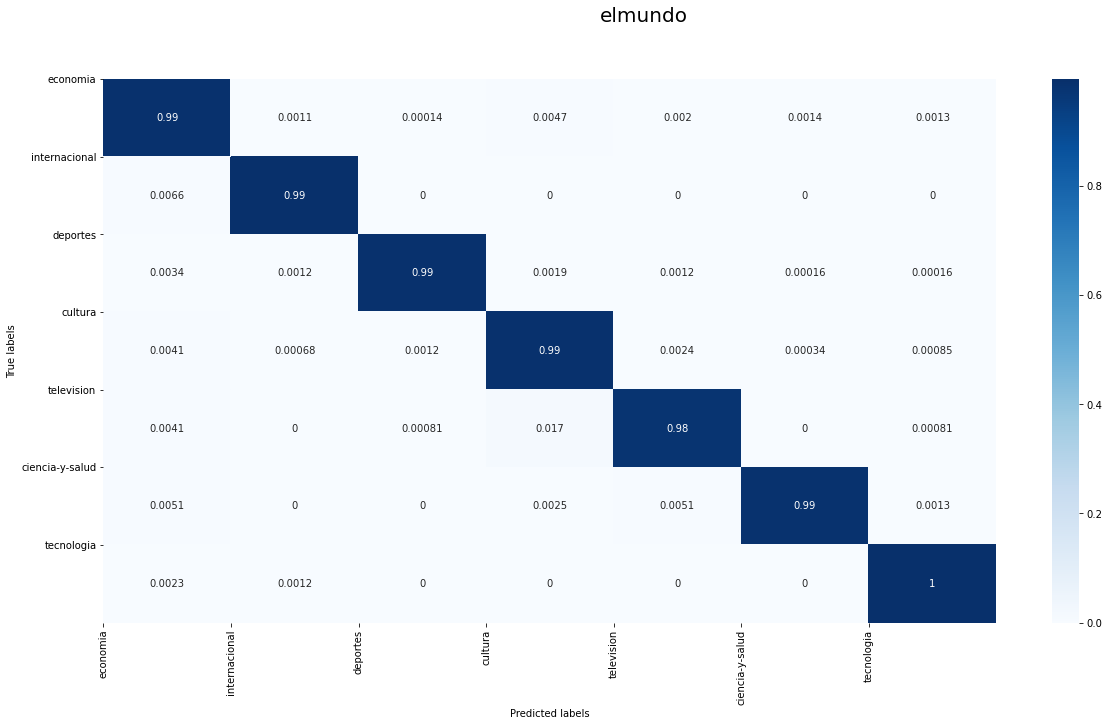

In [14]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))